In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision

import datasets, models, utils, training

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
use_cuda = False
device = torch.device('cuda' if use_cuda else 'cpu')

# Experiment 1: Image Classification

## Run a single experiment

In [92]:
def run_image_classification_experiment(params, name=None, history=None):
    # Load datasets.
    train_dataset, val_dataset, test_dataset = datasets.load_emnist(seed=0)
    noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=params['scaling_factor'])
    
    # Wrap datasets in loaders.
    kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=params['batch_size'], shuffle=True, **kwargs)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=params['batch_size_eval'], shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=params['batch_size_eval'], 
                                              shuffle=False, **kwargs)
    noisy_test_loader = torch.utils.data.DataLoader(noisy_test_dataset, batch_size=params['batch_size_eval'], 
                                                    shuffle=False, **kwargs)
    
    # Load model and optimizer.
    #global model
    model = models.FeedforwardNet(num_hidden=500).to(device)
    #model = models.FeedbackNet(alpha=params['alpha'], num_passes=params['num_passes']).to(device)
    print('Model:', model)
    print('Model has', utils.count_parameters(model), 'trainable parameters')
    optimizer = optim.SGD(model.parameters(), lr=params['learning_rate'], momentum=params['momentum'])

    # Train and test. 
    for epoch in range(params['num_epochs']):
        print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
        start_time = time.time()
        training.train(model, device, train_loader, optimizer, epoch+1)
        print('Took', time.time()-start_time, 'seconds')
        print()
        
        print('Validation set:')
        val_loss, val_acc = training.test(model, device, val_loader)
        print('Test set:')
        test_loss, test_acc = training.test(model, device, test_loader)
        print('Noisy test set:')
        noisy_test_loss, noisy_test_acc = training.test(model, device, noisy_test_loader)
        
        if history:
            history.log('val_loss', val_loss)
            history.log('val_acc', val_acc)
            history.log('test_loss', test_loss)
            history.log('test_acc', test_acc)
            history.log('noisy_test_loss', noisy_test_loss)
            history.log('noisy_test_acc', noisy_test_acc)
            
    return model

In [94]:
params = dict(batch_size=128, batch_size_eval=1000, num_epochs=25, learning_rate=0.02, momentum=0.7, scaling_factor=2, num_passes=2, alpha=0.3)
model = run_image_classification_experiment(params)

Model: FeedforwardNet(
  (forward1): Linear(in_features=784, out_features=500, bias=True)
  (forward2): Linear(in_features=500, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
)
Model has 405526 trainable parameters
Epoch 1/25
Train Epoch: 1 [0/114800 (0%)]	Loss: 3.313779	Accuracy: 3.1%
Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.060840	Accuracy: 62.5%
Train Epoch: 1 [51200/114800 (45%)]	Loss: 0.911609	Accuracy: 71.1%
Train Epoch: 1 [76800/114800 (67%)]	Loss: 0.946411	Accuracy: 71.1%
Train Epoch: 1 [102400/114800 (89%)]	Loss: 0.648329	Accuracy: 78.9%
Took 25.683244943618774 seconds

Validation set:
Evaluation: Average loss: 0.6250, Accuracy: 8179/10000 (81.8%)

Test set:
Evaluation: Average loss: 0.6182, Accuracy: 17014/20800 (81.8%)

Noisy test set:
Evaluation: Average loss: 2.1515, Accuracy: 8368/20800 (40.2%)

Epoch 2/25
Train Epoch: 2 [0/114800 (0%)]	Loss: 0.722163	Accuracy: 76.6%
Train Epoch: 2 [25600/114800 (22%)]	Loss: 0.717424	Accuracy: 75.8%
Train Epoch: 2 [51200/11480

Train Epoch: 14 [25600/114800 (22%)]	Loss: 0.280282	Accuracy: 90.6%
Train Epoch: 14 [51200/114800 (45%)]	Loss: 0.248158	Accuracy: 92.2%
Train Epoch: 14 [76800/114800 (67%)]	Loss: 0.313215	Accuracy: 88.3%
Train Epoch: 14 [102400/114800 (89%)]	Loss: 0.302252	Accuracy: 86.7%
Took 25.148176908493042 seconds

Validation set:
Evaluation: Average loss: 0.3001, Accuracy: 9084/10000 (90.8%)

Test set:
Evaluation: Average loss: 0.3054, Accuracy: 18845/20800 (90.6%)

Noisy test set:
Evaluation: Average loss: 2.4966, Accuracy: 9185/20800 (44.2%)

Epoch 15/25
Train Epoch: 15 [0/114800 (0%)]	Loss: 0.419460	Accuracy: 92.2%
Train Epoch: 15 [25600/114800 (22%)]	Loss: 0.383324	Accuracy: 87.5%
Train Epoch: 15 [51200/114800 (45%)]	Loss: 0.289206	Accuracy: 89.8%
Train Epoch: 15 [76800/114800 (67%)]	Loss: 0.231171	Accuracy: 89.8%
Train Epoch: 15 [102400/114800 (89%)]	Loss: 0.193535	Accuracy: 92.2%
Took 26.75474214553833 seconds

Validation set:
Evaluation: Average loss: 0.2965, Accuracy: 9077/10000 (90.8%)


In [95]:
torch.save(model, 'data/models/ff_net.pt')

## Hyperopt

In [23]:
log_dir = 'logs/3'

param_grid = {'batch_size': [64, 128],
              'batch_size_eval': [1000], 
              'num_epochs': [30], 
              'learning_rate': [0.005, 0.01, 0.02, 0.04], 
              'momentum': [0.3, 0.5, 0.7], 
              'scaling_factor': [2]}#, 
              #'num_passes': [2], 
              #'alpha': [0.3, 0.5, 0.7]}

grid_search = utils.GridSearch(log_dir, param_grid)
grid_search

GridSearch with 24 jobs:
{'index': 0, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 1, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.5, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 2, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.7, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 3, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.01, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 4, 'params': {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.01, 'momentum': 0.5, 'num_epochs': 30, 'scaling_factor': 2}, 'status': 'not started', 'history': ''}
{'index': 5, 'params': {'batch_size':

In [24]:
grid_search.run(run_image_classification_experiment)

Starting hyperparameter optimization (logging to logs/3)
Starting run 0 with parameters {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.005, 'momentum': 0.3, 'num_epochs': 30, 'scaling_factor': 2}
Model: FeedforwardNet(
  (forward1): Linear(in_features=784, out_features=1001, bias=True)
  (forward2): Linear(in_features=1001, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
)
Model has 811837 trainable parameters
Epoch 1/30
Train Epoch: 1 [0/114800 (0%)]	Loss: 3.331424	Accuracy: 3.1%
Train Epoch: 1 [12800/114800 (11%)]	Loss: 2.010264	Accuracy: 43.8%
Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.461244	Accuracy: 57.8%
Train Epoch: 1 [38400/114800 (33%)]	Loss: 1.361619	Accuracy: 62.5%
Train Epoch: 1 [51200/114800 (45%)]	Loss: 1.329793	Accuracy: 65.6%
Train Epoch: 1 [64000/114800 (56%)]	Loss: 1.113868	Accuracy: 70.3%
Train Epoch: 1 [76800/114800 (67%)]	Loss: 1.094762	Accuracy: 70.3%
Train Epoch: 1 [89600/114800 (78%)]	Loss: 1.356751	Accuracy: 60.9%
Train Epoch: 1 [10240

Took 29.83962607383728 seconds

Validation set:
Evaluation: Average loss: 0.4387, Accuracy: 8682/10000 (86.8%)

Test set:
Evaluation: Average loss: 0.4378, Accuracy: 18123/20800 (87.1%)

Noisy test set:
Evaluation: Average loss: 2.0993, Accuracy: 8429/20800 (40.5%)

Epoch 10/30
Train Epoch: 10 [0/114800 (0%)]	Loss: 0.474201	Accuracy: 89.1%
Train Epoch: 10 [12800/114800 (11%)]	Loss: 0.612254	Accuracy: 78.1%
Train Epoch: 10 [25600/114800 (22%)]	Loss: 0.242677	Accuracy: 92.2%
Train Epoch: 10 [38400/114800 (33%)]	Loss: 0.252720	Accuracy: 95.3%
Train Epoch: 10 [51200/114800 (45%)]	Loss: 0.585170	Accuracy: 82.8%
Train Epoch: 10 [64000/114800 (56%)]	Loss: 0.528410	Accuracy: 89.1%
Train Epoch: 10 [76800/114800 (67%)]	Loss: 0.409395	Accuracy: 85.9%
Train Epoch: 10 [89600/114800 (78%)]	Loss: 0.510005	Accuracy: 85.9%
Train Epoch: 10 [102400/114800 (89%)]	Loss: 0.397920	Accuracy: 90.6%
Took 30.065407037734985 seconds

Validation set:
Evaluation: Average loss: 0.4224, Accuracy: 8734/10000 (87.3%)



Train Epoch: 19 [12800/114800 (11%)]	Loss: 0.346257	Accuracy: 82.8%
Train Epoch: 19 [25600/114800 (22%)]	Loss: 0.358913	Accuracy: 89.1%
Train Epoch: 19 [38400/114800 (33%)]	Loss: 0.362647	Accuracy: 87.5%
Train Epoch: 19 [51200/114800 (45%)]	Loss: 0.543324	Accuracy: 89.1%
Train Epoch: 19 [64000/114800 (56%)]	Loss: 0.491841	Accuracy: 92.2%
Train Epoch: 19 [76800/114800 (67%)]	Loss: 0.408707	Accuracy: 87.5%
Train Epoch: 19 [89600/114800 (78%)]	Loss: 0.293818	Accuracy: 90.6%
Train Epoch: 19 [102400/114800 (89%)]	Loss: 0.376921	Accuracy: 85.9%
Took 24.926083087921143 seconds

Validation set:
Evaluation: Average loss: 0.3420, Accuracy: 8964/10000 (89.6%)

Test set:
Evaluation: Average loss: 0.3437, Accuracy: 18632/20800 (89.6%)

Noisy test set:
Evaluation: Average loss: 1.9460, Accuracy: 9343/20800 (44.9%)

Epoch 20/30
Train Epoch: 20 [0/114800 (0%)]	Loss: 0.409866	Accuracy: 89.1%
Train Epoch: 20 [12800/114800 (11%)]	Loss: 0.390446	Accuracy: 85.9%
Train Epoch: 20 [25600/114800 (22%)]	Loss: 0

Train Epoch: 28 [51200/114800 (45%)]	Loss: 0.204535	Accuracy: 90.6%
Train Epoch: 28 [64000/114800 (56%)]	Loss: 0.270431	Accuracy: 92.2%
Train Epoch: 28 [76800/114800 (67%)]	Loss: 0.287486	Accuracy: 90.6%
Train Epoch: 28 [89600/114800 (78%)]	Loss: 0.262505	Accuracy: 92.2%
Train Epoch: 28 [102400/114800 (89%)]	Loss: 0.401719	Accuracy: 87.5%
Took 25.7833411693573 seconds

Validation set:
Evaluation: Average loss: 0.3102, Accuracy: 9046/10000 (90.5%)

Test set:
Evaluation: Average loss: 0.3124, Accuracy: 18816/20800 (90.5%)

Noisy test set:
Evaluation: Average loss: 1.9710, Accuracy: 9421/20800 (45.3%)

Epoch 29/30
Train Epoch: 29 [0/114800 (0%)]	Loss: 0.318105	Accuracy: 92.2%
Train Epoch: 29 [12800/114800 (11%)]	Loss: 0.398551	Accuracy: 87.5%
Train Epoch: 29 [25600/114800 (22%)]	Loss: 0.335917	Accuracy: 89.1%
Train Epoch: 29 [38400/114800 (33%)]	Loss: 0.248074	Accuracy: 95.3%
Train Epoch: 29 [51200/114800 (45%)]	Loss: 0.362163	Accuracy: 89.1%
Train Epoch: 29 [64000/114800 (56%)]	Loss: 0.3

Train Epoch: 7 [25600/114800 (22%)]	Loss: 0.565904	Accuracy: 82.8%
Train Epoch: 7 [38400/114800 (33%)]	Loss: 0.378970	Accuracy: 87.5%
Train Epoch: 7 [51200/114800 (45%)]	Loss: 0.523385	Accuracy: 84.4%
Train Epoch: 7 [64000/114800 (56%)]	Loss: 0.525019	Accuracy: 81.2%
Train Epoch: 7 [76800/114800 (67%)]	Loss: 0.546734	Accuracy: 89.1%
Train Epoch: 7 [89600/114800 (78%)]	Loss: 0.470547	Accuracy: 84.4%
Train Epoch: 7 [102400/114800 (89%)]	Loss: 0.588652	Accuracy: 81.2%
Took 28.601638078689575 seconds

Validation set:
Evaluation: Average loss: 0.4257, Accuracy: 8741/10000 (87.4%)

Test set:
Evaluation: Average loss: 0.4245, Accuracy: 18199/20800 (87.5%)

Noisy test set:
Evaluation: Average loss: 2.1120, Accuracy: 8562/20800 (41.2%)

Epoch 8/30
Train Epoch: 8 [0/114800 (0%)]	Loss: 0.432994	Accuracy: 87.5%
Train Epoch: 8 [12800/114800 (11%)]	Loss: 0.563394	Accuracy: 78.1%
Train Epoch: 8 [25600/114800 (22%)]	Loss: 0.432558	Accuracy: 82.8%
Train Epoch: 8 [38400/114800 (33%)]	Loss: 0.577424	Accu

Train Epoch: 16 [76800/114800 (67%)]	Loss: 0.313167	Accuracy: 85.9%
Train Epoch: 16 [89600/114800 (78%)]	Loss: 0.308154	Accuracy: 93.8%
Train Epoch: 16 [102400/114800 (89%)]	Loss: 0.300135	Accuracy: 90.6%
Took 4244.646044969559 seconds

Validation set:
Evaluation: Average loss: 0.3290, Accuracy: 9008/10000 (90.1%)

Test set:
Evaluation: Average loss: 0.3303, Accuracy: 18704/20800 (89.9%)

Noisy test set:
Evaluation: Average loss: 1.9652, Accuracy: 9249/20800 (44.5%)

Epoch 17/30
Train Epoch: 17 [0/114800 (0%)]	Loss: 0.466203	Accuracy: 87.5%
Train Epoch: 17 [12800/114800 (11%)]	Loss: 0.332095	Accuracy: 95.3%
Train Epoch: 17 [25600/114800 (22%)]	Loss: 0.336896	Accuracy: 89.1%
Train Epoch: 17 [38400/114800 (33%)]	Loss: 0.689647	Accuracy: 82.8%
Train Epoch: 17 [51200/114800 (45%)]	Loss: 0.500596	Accuracy: 84.4%
Train Epoch: 17 [64000/114800 (56%)]	Loss: 0.228831	Accuracy: 90.6%
Train Epoch: 17 [76800/114800 (67%)]	Loss: 0.328752	Accuracy: 93.8%
Train Epoch: 17 [89600/114800 (78%)]	Loss: 0.

Evaluation: Average loss: 0.2989, Accuracy: 9082/10000 (90.8%)

Test set:
Evaluation: Average loss: 0.2992, Accuracy: 18889/20800 (90.8%)

Noisy test set:
Evaluation: Average loss: 1.9668, Accuracy: 9613/20800 (46.2%)

Epoch 26/30
Train Epoch: 26 [0/114800 (0%)]	Loss: 0.281590	Accuracy: 90.6%
Train Epoch: 26 [12800/114800 (11%)]	Loss: 0.249901	Accuracy: 90.6%
Train Epoch: 26 [25600/114800 (22%)]	Loss: 0.443722	Accuracy: 84.4%
Train Epoch: 26 [38400/114800 (33%)]	Loss: 0.274414	Accuracy: 87.5%
Train Epoch: 26 [51200/114800 (45%)]	Loss: 0.275191	Accuracy: 92.2%
Train Epoch: 26 [64000/114800 (56%)]	Loss: 0.380462	Accuracy: 81.2%
Train Epoch: 26 [76800/114800 (67%)]	Loss: 0.247368	Accuracy: 90.6%
Train Epoch: 26 [89600/114800 (78%)]	Loss: 0.230606	Accuracy: 93.8%
Train Epoch: 26 [102400/114800 (89%)]	Loss: 0.293328	Accuracy: 87.5%
Took 27.75101900100708 seconds

Validation set:
Evaluation: Average loss: 0.2935, Accuracy: 9110/10000 (91.1%)

Test set:
Evaluation: Average loss: 0.2966, Accur

Train Epoch: 4 [89600/114800 (78%)]	Loss: 0.550502	Accuracy: 84.4%
Train Epoch: 4 [102400/114800 (89%)]	Loss: 0.660232	Accuracy: 81.2%
Took 34.21739888191223 seconds

Validation set:
Evaluation: Average loss: 0.4344, Accuracy: 8700/10000 (87.0%)

Test set:
Evaluation: Average loss: 0.4338, Accuracy: 18127/20800 (87.1%)

Noisy test set:
Evaluation: Average loss: 2.0917, Accuracy: 8505/20800 (40.9%)

Epoch 5/30
Train Epoch: 5 [0/114800 (0%)]	Loss: 0.525311	Accuracy: 79.7%
Train Epoch: 5 [12800/114800 (11%)]	Loss: 0.696845	Accuracy: 78.1%
Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.460981	Accuracy: 84.4%
Train Epoch: 5 [38400/114800 (33%)]	Loss: 0.704598	Accuracy: 76.6%
Train Epoch: 5 [51200/114800 (45%)]	Loss: 0.582160	Accuracy: 78.1%
Train Epoch: 5 [64000/114800 (56%)]	Loss: 0.525312	Accuracy: 85.9%
Train Epoch: 5 [76800/114800 (67%)]	Loss: 0.405652	Accuracy: 85.9%
Train Epoch: 5 [89600/114800 (78%)]	Loss: 0.514024	Accuracy: 84.4%
Train Epoch: 5 [102400/114800 (89%)]	Loss: 0.348456	Accu

Evaluation: Average loss: 0.3089, Accuracy: 18823/20800 (90.5%)

Noisy test set:
Evaluation: Average loss: 1.9636, Accuracy: 9432/20800 (45.3%)

Epoch 14/30
Train Epoch: 14 [0/114800 (0%)]	Loss: 0.415969	Accuracy: 89.1%
Train Epoch: 14 [12800/114800 (11%)]	Loss: 0.268443	Accuracy: 90.6%
Train Epoch: 14 [25600/114800 (22%)]	Loss: 0.392828	Accuracy: 84.4%
Train Epoch: 14 [38400/114800 (33%)]	Loss: 0.308765	Accuracy: 85.9%
Train Epoch: 14 [51200/114800 (45%)]	Loss: 0.212336	Accuracy: 90.6%
Train Epoch: 14 [64000/114800 (56%)]	Loss: 0.415091	Accuracy: 87.5%
Train Epoch: 14 [76800/114800 (67%)]	Loss: 0.346831	Accuracy: 90.6%
Train Epoch: 14 [89600/114800 (78%)]	Loss: 0.254984	Accuracy: 90.6%
Train Epoch: 14 [102400/114800 (89%)]	Loss: 0.258243	Accuracy: 92.2%
Took 28.744654893875122 seconds

Validation set:
Evaluation: Average loss: 0.3037, Accuracy: 9073/10000 (90.7%)

Test set:
Evaluation: Average loss: 0.3047, Accuracy: 18851/20800 (90.6%)

Noisy test set:
Evaluation: Average loss: 2.032

Train Epoch: 23 [12800/114800 (11%)]	Loss: 0.208223	Accuracy: 92.2%
Train Epoch: 23 [25600/114800 (22%)]	Loss: 0.247522	Accuracy: 90.6%
Train Epoch: 23 [38400/114800 (33%)]	Loss: 0.168073	Accuracy: 93.8%
Train Epoch: 23 [51200/114800 (45%)]	Loss: 0.199938	Accuracy: 90.6%
Train Epoch: 23 [64000/114800 (56%)]	Loss: 0.217071	Accuracy: 93.8%
Train Epoch: 23 [76800/114800 (67%)]	Loss: 0.309308	Accuracy: 84.4%
Train Epoch: 23 [89600/114800 (78%)]	Loss: 0.328399	Accuracy: 89.1%
Train Epoch: 23 [102400/114800 (89%)]	Loss: 0.298123	Accuracy: 89.1%
Took 25.350323915481567 seconds

Validation set:
Evaluation: Average loss: 0.2774, Accuracy: 9163/10000 (91.6%)

Test set:
Evaluation: Average loss: 0.2790, Accuracy: 19003/20800 (91.4%)

Noisy test set:
Evaluation: Average loss: 2.2113, Accuracy: 9287/20800 (44.6%)

Epoch 24/30
Train Epoch: 24 [0/114800 (0%)]	Loss: 0.185713	Accuracy: 95.3%
Train Epoch: 24 [12800/114800 (11%)]	Loss: 0.247830	Accuracy: 98.4%
Train Epoch: 24 [25600/114800 (22%)]	Loss: 0

Evaluation: Average loss: 0.7980, Accuracy: 16115/20800 (77.5%)

Noisy test set:
Evaluation: Average loss: 2.1802, Accuracy: 8261/20800 (39.7%)

Epoch 2/30
Train Epoch: 2 [0/114800 (0%)]	Loss: 0.716233	Accuracy: 79.7%
Train Epoch: 2 [12800/114800 (11%)]	Loss: 0.927414	Accuracy: 75.0%
Train Epoch: 2 [25600/114800 (22%)]	Loss: 0.981292	Accuracy: 70.3%
Train Epoch: 2 [38400/114800 (33%)]	Loss: 0.812718	Accuracy: 71.9%
Train Epoch: 2 [51200/114800 (45%)]	Loss: 0.890331	Accuracy: 76.6%
Train Epoch: 2 [64000/114800 (56%)]	Loss: 0.815139	Accuracy: 78.1%
Train Epoch: 2 [76800/114800 (67%)]	Loss: 0.687557	Accuracy: 78.1%
Train Epoch: 2 [89600/114800 (78%)]	Loss: 0.757714	Accuracy: 78.1%
Train Epoch: 2 [102400/114800 (89%)]	Loss: 0.652263	Accuracy: 78.1%
Took 25.27745819091797 seconds

Validation set:
Evaluation: Average loss: 0.6097, Accuracy: 8217/10000 (82.2%)

Test set:
Evaluation: Average loss: 0.6037, Accuracy: 17177/20800 (82.6%)

Noisy test set:
Evaluation: Average loss: 2.2018, Accuracy

Train Epoch: 11 [25600/114800 (22%)]	Loss: 0.390293	Accuracy: 85.9%
Train Epoch: 11 [38400/114800 (33%)]	Loss: 0.385078	Accuracy: 85.9%
Train Epoch: 11 [51200/114800 (45%)]	Loss: 0.399542	Accuracy: 87.5%
Train Epoch: 11 [64000/114800 (56%)]	Loss: 0.490765	Accuracy: 81.2%
Train Epoch: 11 [76800/114800 (67%)]	Loss: 0.522636	Accuracy: 89.1%
Train Epoch: 11 [89600/114800 (78%)]	Loss: 0.295694	Accuracy: 90.6%
Train Epoch: 11 [102400/114800 (89%)]	Loss: 0.337954	Accuracy: 90.6%
Took 25.29643177986145 seconds

Validation set:
Evaluation: Average loss: 0.3297, Accuracy: 9010/10000 (90.1%)

Test set:
Evaluation: Average loss: 0.3317, Accuracy: 18714/20800 (90.0%)

Noisy test set:
Evaluation: Average loss: 2.0201, Accuracy: 9035/20800 (43.4%)

Epoch 12/30
Train Epoch: 12 [0/114800 (0%)]	Loss: 0.243921	Accuracy: 92.2%
Train Epoch: 12 [12800/114800 (11%)]	Loss: 0.366415	Accuracy: 81.2%
Train Epoch: 12 [25600/114800 (22%)]	Loss: 0.300433	Accuracy: 89.1%
Train Epoch: 12 [38400/114800 (33%)]	Loss: 0.

Train Epoch: 20 [76800/114800 (67%)]	Loss: 0.346301	Accuracy: 92.2%
Train Epoch: 20 [89600/114800 (78%)]	Loss: 0.177831	Accuracy: 95.3%
Train Epoch: 20 [102400/114800 (89%)]	Loss: 0.311552	Accuracy: 93.8%
Took 25.08891487121582 seconds

Validation set:
Evaluation: Average loss: 0.2911, Accuracy: 9104/10000 (91.0%)

Test set:
Evaluation: Average loss: 0.2921, Accuracy: 18932/20800 (91.0%)

Noisy test set:
Evaluation: Average loss: 2.0859, Accuracy: 9265/20800 (44.5%)

Epoch 21/30
Train Epoch: 21 [0/114800 (0%)]	Loss: 0.323442	Accuracy: 90.6%
Train Epoch: 21 [12800/114800 (11%)]	Loss: 0.214343	Accuracy: 90.6%
Train Epoch: 21 [25600/114800 (22%)]	Loss: 0.148205	Accuracy: 95.3%
Train Epoch: 21 [38400/114800 (33%)]	Loss: 0.274646	Accuracy: 93.8%
Train Epoch: 21 [51200/114800 (45%)]	Loss: 0.122392	Accuracy: 96.9%
Train Epoch: 21 [64000/114800 (56%)]	Loss: 0.350607	Accuracy: 92.2%
Train Epoch: 21 [76800/114800 (67%)]	Loss: 0.341009	Accuracy: 90.6%
Train Epoch: 21 [89600/114800 (78%)]	Loss: 0.

Took 24.819892168045044 seconds

Validation set:
Evaluation: Average loss: 0.2744, Accuracy: 9159/10000 (91.6%)

Test set:
Evaluation: Average loss: 0.2752, Accuracy: 19028/20800 (91.5%)

Noisy test set:
Evaluation: Average loss: 2.2365, Accuracy: 9012/20800 (43.3%)

Epoch 30/30
Train Epoch: 30 [0/114800 (0%)]	Loss: 0.137148	Accuracy: 93.8%
Train Epoch: 30 [12800/114800 (11%)]	Loss: 0.194850	Accuracy: 93.8%
Train Epoch: 30 [25600/114800 (22%)]	Loss: 0.156253	Accuracy: 96.9%
Train Epoch: 30 [38400/114800 (33%)]	Loss: 0.216355	Accuracy: 93.8%
Train Epoch: 30 [51200/114800 (45%)]	Loss: 0.295185	Accuracy: 90.6%
Train Epoch: 30 [64000/114800 (56%)]	Loss: 0.125673	Accuracy: 98.4%
Train Epoch: 30 [76800/114800 (67%)]	Loss: 0.183978	Accuracy: 93.8%
Train Epoch: 30 [89600/114800 (78%)]	Loss: 0.221408	Accuracy: 92.2%
Train Epoch: 30 [102400/114800 (89%)]	Loss: 0.331170	Accuracy: 92.2%
Took 24.91506791114807 seconds

Validation set:
Evaluation: Average loss: 0.2749, Accuracy: 9145/10000 (91.5%)



Train Epoch: 8 [89600/114800 (78%)]	Loss: 0.281792	Accuracy: 95.3%
Train Epoch: 8 [102400/114800 (89%)]	Loss: 0.278944	Accuracy: 89.1%
Took 24.831547021865845 seconds

Validation set:
Evaluation: Average loss: 0.3335, Accuracy: 8993/10000 (89.9%)

Test set:
Evaluation: Average loss: 0.3354, Accuracy: 18652/20800 (89.7%)

Noisy test set:
Evaluation: Average loss: 2.0286, Accuracy: 9210/20800 (44.3%)

Epoch 9/30
Train Epoch: 9 [0/114800 (0%)]	Loss: 0.184040	Accuracy: 90.6%
Train Epoch: 9 [12800/114800 (11%)]	Loss: 0.315968	Accuracy: 93.8%
Train Epoch: 9 [25600/114800 (22%)]	Loss: 0.442408	Accuracy: 85.9%
Train Epoch: 9 [38400/114800 (33%)]	Loss: 0.225378	Accuracy: 92.2%
Train Epoch: 9 [51200/114800 (45%)]	Loss: 0.294972	Accuracy: 89.1%
Train Epoch: 9 [64000/114800 (56%)]	Loss: 0.194819	Accuracy: 96.9%
Train Epoch: 9 [76800/114800 (67%)]	Loss: 0.310669	Accuracy: 92.2%
Train Epoch: 9 [89600/114800 (78%)]	Loss: 0.310734	Accuracy: 90.6%
Train Epoch: 9 [102400/114800 (89%)]	Loss: 0.422809	Acc

Evaluation: Average loss: 0.2864, Accuracy: 18953/20800 (91.1%)

Noisy test set:
Evaluation: Average loss: 2.2430, Accuracy: 8972/20800 (43.1%)

Epoch 18/30
Train Epoch: 18 [0/114800 (0%)]	Loss: 0.098222	Accuracy: 98.4%
Train Epoch: 18 [12800/114800 (11%)]	Loss: 0.511154	Accuracy: 85.9%
Train Epoch: 18 [25600/114800 (22%)]	Loss: 0.200287	Accuracy: 95.3%
Train Epoch: 18 [38400/114800 (33%)]	Loss: 0.281925	Accuracy: 95.3%
Train Epoch: 18 [51200/114800 (45%)]	Loss: 0.237291	Accuracy: 89.1%
Train Epoch: 18 [64000/114800 (56%)]	Loss: 0.295813	Accuracy: 93.8%
Train Epoch: 18 [76800/114800 (67%)]	Loss: 0.196626	Accuracy: 90.6%
Train Epoch: 18 [89600/114800 (78%)]	Loss: 0.185841	Accuracy: 93.8%
Train Epoch: 18 [102400/114800 (89%)]	Loss: 0.377513	Accuracy: 89.1%
Took 25.014147996902466 seconds

Validation set:
Evaluation: Average loss: 0.2809, Accuracy: 9122/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.2825, Accuracy: 18983/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 2.315

Train Epoch: 27 [12800/114800 (11%)]	Loss: 0.397888	Accuracy: 87.5%
Train Epoch: 27 [25600/114800 (22%)]	Loss: 0.324114	Accuracy: 87.5%
Train Epoch: 27 [38400/114800 (33%)]	Loss: 0.222946	Accuracy: 93.8%
Train Epoch: 27 [51200/114800 (45%)]	Loss: 0.246261	Accuracy: 89.1%
Train Epoch: 27 [64000/114800 (56%)]	Loss: 0.202516	Accuracy: 90.6%
Train Epoch: 27 [76800/114800 (67%)]	Loss: 0.361972	Accuracy: 85.9%
Train Epoch: 27 [89600/114800 (78%)]	Loss: 0.284047	Accuracy: 89.1%
Train Epoch: 27 [102400/114800 (89%)]	Loss: 0.176368	Accuracy: 93.8%
Took 29.7600519657135 seconds

Validation set:
Evaluation: Average loss: 0.2703, Accuracy: 9158/10000 (91.6%)

Test set:
Evaluation: Average loss: 0.2713, Accuracy: 19039/20800 (91.5%)

Noisy test set:
Evaluation: Average loss: 2.4796, Accuracy: 9123/20800 (43.9%)

Epoch 28/30
Train Epoch: 28 [0/114800 (0%)]	Loss: 0.180674	Accuracy: 93.8%
Train Epoch: 28 [12800/114800 (11%)]	Loss: 0.170549	Accuracy: 93.8%
Train Epoch: 28 [25600/114800 (22%)]	Loss: 0.1

Evaluation: Average loss: 2.1487, Accuracy: 8669/20800 (41.7%)

Epoch 6/30
Train Epoch: 6 [0/114800 (0%)]	Loss: 0.229437	Accuracy: 93.8%
Train Epoch: 6 [12800/114800 (11%)]	Loss: 0.434512	Accuracy: 87.5%
Train Epoch: 6 [25600/114800 (22%)]	Loss: 0.434741	Accuracy: 90.6%
Train Epoch: 6 [38400/114800 (33%)]	Loss: 0.410688	Accuracy: 85.9%
Train Epoch: 6 [51200/114800 (45%)]	Loss: 0.444994	Accuracy: 87.5%
Train Epoch: 6 [64000/114800 (56%)]	Loss: 0.406857	Accuracy: 85.9%
Train Epoch: 6 [76800/114800 (67%)]	Loss: 0.346055	Accuracy: 90.6%
Train Epoch: 6 [89600/114800 (78%)]	Loss: 0.247817	Accuracy: 89.1%
Train Epoch: 6 [102400/114800 (89%)]	Loss: 0.362266	Accuracy: 85.9%
Took 32.68785095214844 seconds

Validation set:
Evaluation: Average loss: 0.3223, Accuracy: 8990/10000 (89.9%)

Test set:
Evaluation: Average loss: 0.3255, Accuracy: 18727/20800 (90.0%)

Noisy test set:
Evaluation: Average loss: 2.1361, Accuracy: 9070/20800 (43.6%)

Epoch 7/30
Train Epoch: 7 [0/114800 (0%)]	Loss: 0.590897	Ac

Train Epoch: 15 [38400/114800 (33%)]	Loss: 0.350788	Accuracy: 93.8%
Train Epoch: 15 [51200/114800 (45%)]	Loss: 0.263497	Accuracy: 87.5%
Train Epoch: 15 [64000/114800 (56%)]	Loss: 0.302268	Accuracy: 90.6%
Train Epoch: 15 [76800/114800 (67%)]	Loss: 0.186169	Accuracy: 93.8%
Train Epoch: 15 [89600/114800 (78%)]	Loss: 0.236607	Accuracy: 93.8%
Train Epoch: 15 [102400/114800 (89%)]	Loss: 0.258624	Accuracy: 89.1%
Took 32.23977303504944 seconds

Validation set:
Evaluation: Average loss: 0.2744, Accuracy: 9132/10000 (91.3%)

Test set:
Evaluation: Average loss: 0.2765, Accuracy: 19011/20800 (91.4%)

Noisy test set:
Evaluation: Average loss: 2.5841, Accuracy: 8792/20800 (42.3%)

Epoch 16/30
Train Epoch: 16 [0/114800 (0%)]	Loss: 0.210928	Accuracy: 92.2%
Train Epoch: 16 [12800/114800 (11%)]	Loss: 0.178143	Accuracy: 93.8%
Train Epoch: 16 [25600/114800 (22%)]	Loss: 0.189276	Accuracy: 96.9%
Train Epoch: 16 [38400/114800 (33%)]	Loss: 0.247577	Accuracy: 90.6%
Train Epoch: 16 [51200/114800 (45%)]	Loss: 0.

Train Epoch: 24 [89600/114800 (78%)]	Loss: 0.286630	Accuracy: 89.1%
Train Epoch: 24 [102400/114800 (89%)]	Loss: 0.091594	Accuracy: 100.0%
Took 32.04636812210083 seconds

Validation set:
Evaluation: Average loss: 0.2628, Accuracy: 9186/10000 (91.9%)

Test set:
Evaluation: Average loss: 0.2655, Accuracy: 19120/20800 (91.9%)

Noisy test set:
Evaluation: Average loss: 3.1680, Accuracy: 8329/20800 (40.0%)

Epoch 25/30
Train Epoch: 25 [0/114800 (0%)]	Loss: 0.180020	Accuracy: 93.8%
Train Epoch: 25 [12800/114800 (11%)]	Loss: 0.189786	Accuracy: 90.6%
Train Epoch: 25 [25600/114800 (22%)]	Loss: 0.129320	Accuracy: 96.9%
Train Epoch: 25 [38400/114800 (33%)]	Loss: 0.205849	Accuracy: 92.2%
Train Epoch: 25 [51200/114800 (45%)]	Loss: 0.186392	Accuracy: 93.8%
Train Epoch: 25 [64000/114800 (56%)]	Loss: 0.203773	Accuracy: 93.8%
Train Epoch: 25 [76800/114800 (67%)]	Loss: 0.327962	Accuracy: 89.1%
Train Epoch: 25 [89600/114800 (78%)]	Loss: 0.279649	Accuracy: 87.5%
Train Epoch: 25 [102400/114800 (89%)]	Loss: 

Train Epoch: 3 [51200/114800 (45%)]	Loss: 0.318466	Accuracy: 89.1%
Train Epoch: 3 [64000/114800 (56%)]	Loss: 0.436336	Accuracy: 89.1%
Train Epoch: 3 [76800/114800 (67%)]	Loss: 0.311592	Accuracy: 90.6%
Train Epoch: 3 [89600/114800 (78%)]	Loss: 0.708605	Accuracy: 81.2%
Train Epoch: 3 [102400/114800 (89%)]	Loss: 0.463555	Accuracy: 84.4%
Took 31.740416049957275 seconds

Validation set:
Evaluation: Average loss: 0.4099, Accuracy: 8784/10000 (87.8%)

Test set:
Evaluation: Average loss: 0.4076, Accuracy: 18207/20800 (87.5%)

Noisy test set:
Evaluation: Average loss: 2.0901, Accuracy: 8724/20800 (41.9%)

Epoch 4/30
Train Epoch: 4 [0/114800 (0%)]	Loss: 0.430687	Accuracy: 84.4%
Train Epoch: 4 [12800/114800 (11%)]	Loss: 0.470184	Accuracy: 87.5%
Train Epoch: 4 [25600/114800 (22%)]	Loss: 0.344459	Accuracy: 84.4%
Train Epoch: 4 [38400/114800 (33%)]	Loss: 0.541283	Accuracy: 81.2%
Train Epoch: 4 [51200/114800 (45%)]	Loss: 0.382282	Accuracy: 85.9%
Train Epoch: 4 [64000/114800 (56%)]	Loss: 0.320404	Accu

Train Epoch: 12 [102400/114800 (89%)]	Loss: 0.151032	Accuracy: 96.9%
Took 31.961179971694946 seconds

Validation set:
Evaluation: Average loss: 0.2853, Accuracy: 9132/10000 (91.3%)

Test set:
Evaluation: Average loss: 0.2890, Accuracy: 18929/20800 (91.0%)

Noisy test set:
Evaluation: Average loss: 2.2568, Accuracy: 8978/20800 (43.2%)

Epoch 13/30
Train Epoch: 13 [0/114800 (0%)]	Loss: 0.349396	Accuracy: 89.1%
Train Epoch: 13 [12800/114800 (11%)]	Loss: 0.225870	Accuracy: 89.1%
Train Epoch: 13 [25600/114800 (22%)]	Loss: 0.327969	Accuracy: 85.9%
Train Epoch: 13 [38400/114800 (33%)]	Loss: 0.175553	Accuracy: 93.8%
Train Epoch: 13 [51200/114800 (45%)]	Loss: 0.213009	Accuracy: 92.2%
Train Epoch: 13 [64000/114800 (56%)]	Loss: 0.326791	Accuracy: 93.8%
Train Epoch: 13 [76800/114800 (67%)]	Loss: 0.147136	Accuracy: 95.3%
Train Epoch: 13 [89600/114800 (78%)]	Loss: 0.220762	Accuracy: 90.6%
Train Epoch: 13 [102400/114800 (89%)]	Loss: 0.476404	Accuracy: 87.5%
Took 31.904276371002197 seconds

Validation

Evaluation: Average loss: 2.8126, Accuracy: 8460/20800 (40.7%)

Epoch 22/30
Train Epoch: 22 [0/114800 (0%)]	Loss: 0.084860	Accuracy: 100.0%
Train Epoch: 22 [12800/114800 (11%)]	Loss: 0.178656	Accuracy: 92.2%
Train Epoch: 22 [25600/114800 (22%)]	Loss: 0.307323	Accuracy: 93.8%
Train Epoch: 22 [38400/114800 (33%)]	Loss: 0.276630	Accuracy: 93.8%
Train Epoch: 22 [51200/114800 (45%)]	Loss: 0.260412	Accuracy: 89.1%
Train Epoch: 22 [64000/114800 (56%)]	Loss: 0.187781	Accuracy: 93.8%
Train Epoch: 22 [76800/114800 (67%)]	Loss: 0.184364	Accuracy: 92.2%
Train Epoch: 22 [89600/114800 (78%)]	Loss: 0.292727	Accuracy: 90.6%
Train Epoch: 22 [102400/114800 (89%)]	Loss: 0.215607	Accuracy: 90.6%
Took 31.617701768875122 seconds

Validation set:
Evaluation: Average loss: 0.2700, Accuracy: 9146/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2717, Accuracy: 19065/20800 (91.7%)

Noisy test set:
Evaluation: Average loss: 2.8561, Accuracy: 8528/20800 (41.0%)

Epoch 23/30
Train Epoch: 23 [0/114800 (0%)]	Los

Train Epoch: 1 [12800/114800 (11%)]	Loss: 1.071531	Accuracy: 62.5%
Train Epoch: 1 [25600/114800 (22%)]	Loss: 0.982931	Accuracy: 68.8%
Train Epoch: 1 [38400/114800 (33%)]	Loss: 1.012318	Accuracy: 73.4%
Train Epoch: 1 [51200/114800 (45%)]	Loss: 0.920399	Accuracy: 75.0%
Train Epoch: 1 [64000/114800 (56%)]	Loss: 0.769632	Accuracy: 75.0%
Train Epoch: 1 [76800/114800 (67%)]	Loss: 0.703387	Accuracy: 79.7%
Train Epoch: 1 [89600/114800 (78%)]	Loss: 0.964994	Accuracy: 73.4%
Train Epoch: 1 [102400/114800 (89%)]	Loss: 0.452314	Accuracy: 82.8%
Took 29.2982337474823 seconds

Validation set:
Evaluation: Average loss: 0.5495, Accuracy: 8401/10000 (84.0%)

Test set:
Evaluation: Average loss: 0.5479, Accuracy: 17421/20800 (83.8%)

Noisy test set:
Evaluation: Average loss: 2.0938, Accuracy: 8664/20800 (41.7%)

Epoch 2/30
Train Epoch: 2 [0/114800 (0%)]	Loss: 0.473798	Accuracy: 85.9%
Train Epoch: 2 [12800/114800 (11%)]	Loss: 0.597583	Accuracy: 78.1%
Train Epoch: 2 [25600/114800 (22%)]	Loss: 0.758996	Accura

Train Epoch: 10 [76800/114800 (67%)]	Loss: 0.312418	Accuracy: 85.9%
Train Epoch: 10 [89600/114800 (78%)]	Loss: 0.498506	Accuracy: 89.1%
Train Epoch: 10 [102400/114800 (89%)]	Loss: 0.250265	Accuracy: 92.2%
Took 25.134546041488647 seconds

Validation set:
Evaluation: Average loss: 0.2857, Accuracy: 9116/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.2874, Accuracy: 18927/20800 (91.0%)

Noisy test set:
Evaluation: Average loss: 2.3500, Accuracy: 9348/20800 (44.9%)

Epoch 11/30
Train Epoch: 11 [0/114800 (0%)]	Loss: 0.335196	Accuracy: 90.6%
Train Epoch: 11 [12800/114800 (11%)]	Loss: 0.224110	Accuracy: 90.6%
Train Epoch: 11 [25600/114800 (22%)]	Loss: 0.271840	Accuracy: 90.6%
Train Epoch: 11 [38400/114800 (33%)]	Loss: 0.294445	Accuracy: 89.1%
Train Epoch: 11 [51200/114800 (45%)]	Loss: 0.318284	Accuracy: 90.6%
Train Epoch: 11 [64000/114800 (56%)]	Loss: 0.430824	Accuracy: 84.4%
Train Epoch: 11 [76800/114800 (67%)]	Loss: 0.589166	Accuracy: 87.5%
Train Epoch: 11 [89600/114800 (78%)]	Loss: 0

Took 25.32633328437805 seconds

Validation set:
Evaluation: Average loss: 0.2710, Accuracy: 9167/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2721, Accuracy: 19034/20800 (91.5%)

Noisy test set:
Evaluation: Average loss: 3.0877, Accuracy: 8616/20800 (41.4%)

Epoch 20/30
Train Epoch: 20 [0/114800 (0%)]	Loss: 0.374173	Accuracy: 89.1%
Train Epoch: 20 [12800/114800 (11%)]	Loss: 0.216975	Accuracy: 90.6%
Train Epoch: 20 [25600/114800 (22%)]	Loss: 0.130586	Accuracy: 93.8%
Train Epoch: 20 [38400/114800 (33%)]	Loss: 0.238157	Accuracy: 90.6%
Train Epoch: 20 [51200/114800 (45%)]	Loss: 0.182179	Accuracy: 92.2%
Train Epoch: 20 [64000/114800 (56%)]	Loss: 0.109575	Accuracy: 96.9%
Train Epoch: 20 [76800/114800 (67%)]	Loss: 0.350785	Accuracy: 89.1%
Train Epoch: 20 [89600/114800 (78%)]	Loss: 0.146248	Accuracy: 93.8%
Train Epoch: 20 [102400/114800 (89%)]	Loss: 0.197452	Accuracy: 95.3%
Took 25.160375118255615 seconds

Validation set:
Evaluation: Average loss: 0.2665, Accuracy: 9167/10000 (91.7%)



Evaluation: Average loss: 4.0430, Accuracy: 8042/20800 (38.7%)

Epoch 29/30
Train Epoch: 29 [0/114800 (0%)]	Loss: 0.250456	Accuracy: 95.3%
Train Epoch: 29 [12800/114800 (11%)]	Loss: 0.213380	Accuracy: 92.2%
Train Epoch: 29 [25600/114800 (22%)]	Loss: 0.253291	Accuracy: 90.6%
Train Epoch: 29 [38400/114800 (33%)]	Loss: 0.088484	Accuracy: 98.4%
Train Epoch: 29 [51200/114800 (45%)]	Loss: 0.210521	Accuracy: 95.3%
Train Epoch: 29 [64000/114800 (56%)]	Loss: 0.156987	Accuracy: 92.2%
Train Epoch: 29 [76800/114800 (67%)]	Loss: 0.096483	Accuracy: 98.4%
Train Epoch: 29 [89600/114800 (78%)]	Loss: 0.240839	Accuracy: 92.2%
Train Epoch: 29 [102400/114800 (89%)]	Loss: 0.192258	Accuracy: 92.2%
Took 25.364590167999268 seconds

Validation set:
Evaluation: Average loss: 0.2672, Accuracy: 9204/10000 (92.0%)

Test set:
Evaluation: Average loss: 0.2670, Accuracy: 19121/20800 (91.9%)

Noisy test set:
Evaluation: Average loss: 3.9463, Accuracy: 8191/20800 (39.4%)

Epoch 30/30
Train Epoch: 30 [0/114800 (0%)]	Loss

Evaluation: Average loss: 0.2946, Accuracy: 9075/10000 (90.8%)

Test set:
Evaluation: Average loss: 0.2952, Accuracy: 18881/20800 (90.8%)

Noisy test set:
Evaluation: Average loss: 2.6202, Accuracy: 9271/20800 (44.6%)

Epoch 8/30
Train Epoch: 8 [0/114800 (0%)]	Loss: 0.490827	Accuracy: 81.2%
Train Epoch: 8 [12800/114800 (11%)]	Loss: 0.205240	Accuracy: 90.6%
Train Epoch: 8 [25600/114800 (22%)]	Loss: 0.479720	Accuracy: 84.4%
Train Epoch: 8 [38400/114800 (33%)]	Loss: 0.401185	Accuracy: 82.8%
Train Epoch: 8 [51200/114800 (45%)]	Loss: 0.258751	Accuracy: 85.9%
Train Epoch: 8 [64000/114800 (56%)]	Loss: 0.390931	Accuracy: 84.4%
Train Epoch: 8 [76800/114800 (67%)]	Loss: 0.202356	Accuracy: 92.2%
Train Epoch: 8 [89600/114800 (78%)]	Loss: 0.260499	Accuracy: 93.8%
Train Epoch: 8 [102400/114800 (89%)]	Loss: 0.246793	Accuracy: 87.5%
Took 25.000739097595215 seconds

Validation set:
Evaluation: Average loss: 0.2880, Accuracy: 9095/10000 (91.0%)

Test set:
Evaluation: Average loss: 0.2914, Accuracy: 1888

Train Epoch: 17 [12800/114800 (11%)]	Loss: 0.275794	Accuracy: 95.3%
Train Epoch: 17 [25600/114800 (22%)]	Loss: 0.181575	Accuracy: 92.2%
Train Epoch: 17 [38400/114800 (33%)]	Loss: 0.255667	Accuracy: 90.6%
Train Epoch: 17 [51200/114800 (45%)]	Loss: 0.373369	Accuracy: 84.4%
Train Epoch: 17 [64000/114800 (56%)]	Loss: 0.104961	Accuracy: 93.8%
Train Epoch: 17 [76800/114800 (67%)]	Loss: 0.136968	Accuracy: 93.8%
Train Epoch: 17 [89600/114800 (78%)]	Loss: 0.136248	Accuracy: 92.2%
Train Epoch: 17 [102400/114800 (89%)]	Loss: 0.211389	Accuracy: 92.2%
Took 25.06265115737915 seconds

Validation set:
Evaluation: Average loss: 0.2741, Accuracy: 9166/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2803, Accuracy: 19030/20800 (91.5%)

Noisy test set:
Evaluation: Average loss: 4.3754, Accuracy: 8055/20800 (38.7%)

Epoch 18/30
Train Epoch: 18 [0/114800 (0%)]	Loss: 0.070319	Accuracy: 98.4%
Train Epoch: 18 [12800/114800 (11%)]	Loss: 0.198350	Accuracy: 95.3%
Train Epoch: 18 [25600/114800 (22%)]	Loss: 0.

Train Epoch: 26 [64000/114800 (56%)]	Loss: 0.325951	Accuracy: 85.9%
Train Epoch: 26 [76800/114800 (67%)]	Loss: 0.181576	Accuracy: 92.2%
Train Epoch: 26 [89600/114800 (78%)]	Loss: 0.100641	Accuracy: 95.3%
Train Epoch: 26 [102400/114800 (89%)]	Loss: 0.196721	Accuracy: 93.8%
Took 24.982660055160522 seconds

Validation set:
Evaluation: Average loss: 0.2814, Accuracy: 9162/10000 (91.6%)

Test set:
Evaluation: Average loss: 0.2818, Accuracy: 19141/20800 (92.0%)

Noisy test set:
Evaluation: Average loss: 5.9252, Accuracy: 7761/20800 (37.3%)

Epoch 27/30
Train Epoch: 27 [0/114800 (0%)]	Loss: 0.150525	Accuracy: 95.3%
Train Epoch: 27 [12800/114800 (11%)]	Loss: 0.283663	Accuracy: 87.5%
Train Epoch: 27 [25600/114800 (22%)]	Loss: 0.247193	Accuracy: 89.1%
Train Epoch: 27 [38400/114800 (33%)]	Loss: 0.137546	Accuracy: 92.2%
Train Epoch: 27 [51200/114800 (45%)]	Loss: 0.190303	Accuracy: 89.1%
Train Epoch: 27 [64000/114800 (56%)]	Loss: 0.257671	Accuracy: 90.6%
Train Epoch: 27 [76800/114800 (67%)]	Loss: 0

Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.379547	Accuracy: 85.9%
Train Epoch: 5 [38400/114800 (33%)]	Loss: 0.509305	Accuracy: 82.8%
Train Epoch: 5 [51200/114800 (45%)]	Loss: 0.491749	Accuracy: 82.8%
Train Epoch: 5 [64000/114800 (56%)]	Loss: 0.354069	Accuracy: 87.5%
Train Epoch: 5 [76800/114800 (67%)]	Loss: 0.370065	Accuracy: 79.7%
Train Epoch: 5 [89600/114800 (78%)]	Loss: 0.395370	Accuracy: 89.1%
Train Epoch: 5 [102400/114800 (89%)]	Loss: 0.222592	Accuracy: 95.3%
Took 26.353190898895264 seconds

Validation set:
Evaluation: Average loss: 0.3132, Accuracy: 9033/10000 (90.3%)

Test set:
Evaluation: Average loss: 0.3176, Accuracy: 18719/20800 (90.0%)

Noisy test set:
Evaluation: Average loss: 2.4480, Accuracy: 8706/20800 (41.9%)

Epoch 6/30
Train Epoch: 6 [0/114800 (0%)]	Loss: 0.228148	Accuracy: 90.6%
Train Epoch: 6 [12800/114800 (11%)]	Loss: 0.389333	Accuracy: 85.9%
Train Epoch: 6 [25600/114800 (22%)]	Loss: 0.371583	Accuracy: 87.5%
Train Epoch: 6 [38400/114800 (33%)]	Loss: 0.329587	Accu

Train Epoch: 14 [76800/114800 (67%)]	Loss: 0.219314	Accuracy: 89.1%
Train Epoch: 14 [89600/114800 (78%)]	Loss: 0.199861	Accuracy: 93.8%
Train Epoch: 14 [102400/114800 (89%)]	Loss: 0.184633	Accuracy: 92.2%
Took 26.892619132995605 seconds

Validation set:
Evaluation: Average loss: 0.2765, Accuracy: 9147/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2755, Accuracy: 19054/20800 (91.6%)

Noisy test set:
Evaluation: Average loss: 3.5573, Accuracy: 8115/20800 (39.0%)

Epoch 15/30
Train Epoch: 15 [0/114800 (0%)]	Loss: 0.155063	Accuracy: 98.4%
Train Epoch: 15 [12800/114800 (11%)]	Loss: 0.306216	Accuracy: 85.9%
Train Epoch: 15 [25600/114800 (22%)]	Loss: 0.298351	Accuracy: 85.9%
Train Epoch: 15 [38400/114800 (33%)]	Loss: 0.286513	Accuracy: 96.9%
Train Epoch: 15 [51200/114800 (45%)]	Loss: 0.204303	Accuracy: 90.6%
Train Epoch: 15 [64000/114800 (56%)]	Loss: 0.164864	Accuracy: 93.8%
Train Epoch: 15 [76800/114800 (67%)]	Loss: 0.145396	Accuracy: 98.4%
Train Epoch: 15 [89600/114800 (78%)]	Loss: 0

Took 26.32704210281372 seconds

Validation set:
Evaluation: Average loss: 0.2739, Accuracy: 9188/10000 (91.9%)

Test set:
Evaluation: Average loss: 0.2743, Accuracy: 19114/20800 (91.9%)

Noisy test set:
Evaluation: Average loss: 4.7773, Accuracy: 7692/20800 (37.0%)

Epoch 24/30
Train Epoch: 24 [0/114800 (0%)]	Loss: 0.127317	Accuracy: 96.9%
Train Epoch: 24 [12800/114800 (11%)]	Loss: 0.238592	Accuracy: 95.3%
Train Epoch: 24 [25600/114800 (22%)]	Loss: 0.231982	Accuracy: 90.6%
Train Epoch: 24 [38400/114800 (33%)]	Loss: 0.172764	Accuracy: 92.2%
Train Epoch: 24 [51200/114800 (45%)]	Loss: 0.182798	Accuracy: 95.3%
Train Epoch: 24 [64000/114800 (56%)]	Loss: 0.150314	Accuracy: 93.8%
Train Epoch: 24 [76800/114800 (67%)]	Loss: 0.240075	Accuracy: 90.6%
Train Epoch: 24 [89600/114800 (78%)]	Loss: 0.160873	Accuracy: 92.2%
Train Epoch: 24 [102400/114800 (89%)]	Loss: 0.073835	Accuracy: 98.4%
Took 26.462672233581543 seconds

Validation set:
Evaluation: Average loss: 0.2741, Accuracy: 9174/10000 (91.7%)



Train Epoch: 2 [76800/114800 (67%)]	Loss: 0.383462	Accuracy: 84.4%
Train Epoch: 2 [89600/114800 (78%)]	Loss: 0.541968	Accuracy: 82.8%
Train Epoch: 2 [102400/114800 (89%)]	Loss: 0.429258	Accuracy: 87.5%
Took 24.983354806900024 seconds

Validation set:
Evaluation: Average loss: 0.3749, Accuracy: 8843/10000 (88.4%)

Test set:
Evaluation: Average loss: 0.3762, Accuracy: 18341/20800 (88.2%)

Noisy test set:
Evaluation: Average loss: 2.1933, Accuracy: 9234/20800 (44.4%)

Epoch 3/30
Train Epoch: 3 [0/114800 (0%)]	Loss: 0.492565	Accuracy: 87.5%
Train Epoch: 3 [12800/114800 (11%)]	Loss: 0.535672	Accuracy: 82.8%
Train Epoch: 3 [25600/114800 (22%)]	Loss: 0.426320	Accuracy: 87.5%
Train Epoch: 3 [38400/114800 (33%)]	Loss: 0.308484	Accuracy: 89.1%
Train Epoch: 3 [51200/114800 (45%)]	Loss: 0.231171	Accuracy: 92.2%
Train Epoch: 3 [64000/114800 (56%)]	Loss: 0.275935	Accuracy: 96.9%
Train Epoch: 3 [76800/114800 (67%)]	Loss: 0.263574	Accuracy: 90.6%
Train Epoch: 3 [89600/114800 (78%)]	Loss: 0.559859	Accu

Evaluation: Average loss: 0.2863, Accuracy: 18993/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 3.9774, Accuracy: 8226/20800 (39.5%)

Epoch 12/30
Train Epoch: 12 [0/114800 (0%)]	Loss: 0.136328	Accuracy: 95.3%
Train Epoch: 12 [12800/114800 (11%)]	Loss: 0.203657	Accuracy: 92.2%
Train Epoch: 12 [25600/114800 (22%)]	Loss: 0.270903	Accuracy: 92.2%
Train Epoch: 12 [38400/114800 (33%)]	Loss: 0.293055	Accuracy: 84.4%
Train Epoch: 12 [51200/114800 (45%)]	Loss: 0.200948	Accuracy: 90.6%
Train Epoch: 12 [64000/114800 (56%)]	Loss: 0.351753	Accuracy: 87.5%
Train Epoch: 12 [76800/114800 (67%)]	Loss: 0.118074	Accuracy: 96.9%
Train Epoch: 12 [89600/114800 (78%)]	Loss: 0.246086	Accuracy: 92.2%
Train Epoch: 12 [102400/114800 (89%)]	Loss: 0.106875	Accuracy: 95.3%
Took 25.22184705734253 seconds

Validation set:
Evaluation: Average loss: 0.2839, Accuracy: 9146/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2837, Accuracy: 18962/20800 (91.2%)

Noisy test set:
Evaluation: Average loss: 4.3128

Train Epoch: 21 [12800/114800 (11%)]	Loss: 0.069475	Accuracy: 96.9%
Train Epoch: 21 [25600/114800 (22%)]	Loss: 0.117993	Accuracy: 95.3%
Train Epoch: 21 [38400/114800 (33%)]	Loss: 0.203001	Accuracy: 92.2%
Train Epoch: 21 [51200/114800 (45%)]	Loss: 0.095846	Accuracy: 98.4%
Train Epoch: 21 [64000/114800 (56%)]	Loss: 0.252252	Accuracy: 92.2%
Train Epoch: 21 [76800/114800 (67%)]	Loss: 0.181043	Accuracy: 93.8%
Train Epoch: 21 [89600/114800 (78%)]	Loss: 0.136171	Accuracy: 93.8%
Train Epoch: 21 [102400/114800 (89%)]	Loss: 0.205783	Accuracy: 92.2%
Took 30.490267992019653 seconds

Validation set:
Evaluation: Average loss: 0.2875, Accuracy: 9175/10000 (91.8%)

Test set:
Evaluation: Average loss: 0.2894, Accuracy: 19093/20800 (91.8%)

Noisy test set:
Evaluation: Average loss: 5.8980, Accuracy: 7630/20800 (36.7%)

Epoch 22/30
Train Epoch: 22 [0/114800 (0%)]	Loss: 0.085380	Accuracy: 95.3%
Train Epoch: 22 [12800/114800 (11%)]	Loss: 0.262663	Accuracy: 93.8%
Train Epoch: 22 [25600/114800 (22%)]	Loss: 0

Train Epoch: 30 [51200/114800 (45%)]	Loss: 0.177855	Accuracy: 95.3%
Train Epoch: 30 [64000/114800 (56%)]	Loss: 0.140356	Accuracy: 93.8%
Train Epoch: 30 [76800/114800 (67%)]	Loss: 0.223118	Accuracy: 85.9%
Train Epoch: 30 [89600/114800 (78%)]	Loss: 0.151505	Accuracy: 92.2%
Train Epoch: 30 [102400/114800 (89%)]	Loss: 0.217830	Accuracy: 93.8%
Took 30.833807945251465 seconds

Validation set:
Evaluation: Average loss: 0.2916, Accuracy: 9174/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2982, Accuracy: 19094/20800 (91.8%)

Noisy test set:
Evaluation: Average loss: 7.2982, Accuracy: 7497/20800 (36.0%)

Starting run 11 with parameters {'batch_size': 64, 'batch_size_eval': 1000, 'learning_rate': 0.04, 'momentum': 0.7, 'num_epochs': 30, 'scaling_factor': 2}
Model: FeedforwardNet(
  (forward1): Linear(in_features=784, out_features=1001, bias=True)
  (forward2): Linear(in_features=1001, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
)
Model has 811837 trainable parameters
Epoch 1/30

Train Epoch: 9 [25600/114800 (22%)]	Loss: 0.407337	Accuracy: 85.9%
Train Epoch: 9 [38400/114800 (33%)]	Loss: 0.160054	Accuracy: 96.9%
Train Epoch: 9 [51200/114800 (45%)]	Loss: 0.290379	Accuracy: 92.2%
Train Epoch: 9 [64000/114800 (56%)]	Loss: 0.270101	Accuracy: 92.2%
Train Epoch: 9 [76800/114800 (67%)]	Loss: 0.325095	Accuracy: 89.1%
Train Epoch: 9 [89600/114800 (78%)]	Loss: 0.182022	Accuracy: 93.8%
Train Epoch: 9 [102400/114800 (89%)]	Loss: 0.287310	Accuracy: 87.5%
Took 29.465819120407104 seconds

Validation set:
Evaluation: Average loss: 0.3103, Accuracy: 9099/10000 (91.0%)

Test set:
Evaluation: Average loss: 0.2996, Accuracy: 18932/20800 (91.0%)

Noisy test set:
Evaluation: Average loss: 5.4373, Accuracy: 8371/20800 (40.2%)

Epoch 10/30
Train Epoch: 10 [0/114800 (0%)]	Loss: 0.250011	Accuracy: 87.5%
Train Epoch: 10 [12800/114800 (11%)]	Loss: 0.386392	Accuracy: 90.6%
Train Epoch: 10 [25600/114800 (22%)]	Loss: 0.178572	Accuracy: 93.8%
Train Epoch: 10 [38400/114800 (33%)]	Loss: 0.155445

Train Epoch: 18 [76800/114800 (67%)]	Loss: 0.243760	Accuracy: 92.2%
Train Epoch: 18 [89600/114800 (78%)]	Loss: 0.126580	Accuracy: 95.3%
Train Epoch: 18 [102400/114800 (89%)]	Loss: 0.348309	Accuracy: 87.5%
Took 30.90826416015625 seconds

Validation set:
Evaluation: Average loss: 0.3158, Accuracy: 9115/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.3131, Accuracy: 18993/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 9.2260, Accuracy: 7834/20800 (37.7%)

Epoch 19/30
Train Epoch: 19 [0/114800 (0%)]	Loss: 0.164262	Accuracy: 95.3%
Train Epoch: 19 [12800/114800 (11%)]	Loss: 0.239550	Accuracy: 90.6%
Train Epoch: 19 [25600/114800 (22%)]	Loss: 0.153097	Accuracy: 95.3%
Train Epoch: 19 [38400/114800 (33%)]	Loss: 0.309749	Accuracy: 90.6%
Train Epoch: 19 [51200/114800 (45%)]	Loss: 0.214419	Accuracy: 89.1%
Train Epoch: 19 [64000/114800 (56%)]	Loss: 0.322664	Accuracy: 90.6%
Train Epoch: 19 [76800/114800 (67%)]	Loss: 0.331933	Accuracy: 90.6%
Train Epoch: 19 [89600/114800 (78%)]	Loss: 0.

Took 26.31171202659607 seconds

Validation set:
Evaluation: Average loss: 0.3289, Accuracy: 9156/10000 (91.6%)

Test set:
Evaluation: Average loss: 0.3337, Accuracy: 18990/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 11.5598, Accuracy: 7994/20800 (38.4%)

Epoch 28/30
Train Epoch: 28 [0/114800 (0%)]	Loss: 0.164360	Accuracy: 93.8%
Train Epoch: 28 [12800/114800 (11%)]	Loss: 0.223762	Accuracy: 90.6%
Train Epoch: 28 [25600/114800 (22%)]	Loss: 0.071533	Accuracy: 96.9%
Train Epoch: 28 [38400/114800 (33%)]	Loss: 0.132608	Accuracy: 93.8%
Train Epoch: 28 [51200/114800 (45%)]	Loss: 0.257773	Accuracy: 92.2%
Train Epoch: 28 [64000/114800 (56%)]	Loss: 0.379763	Accuracy: 89.1%
Train Epoch: 28 [76800/114800 (67%)]	Loss: 0.067205	Accuracy: 98.4%
Train Epoch: 28 [89600/114800 (78%)]	Loss: 0.225967	Accuracy: 95.3%
Train Epoch: 28 [102400/114800 (89%)]	Loss: 0.328191	Accuracy: 89.1%
Took 25.63746404647827 seconds

Validation set:
Evaluation: Average loss: 0.3362, Accuracy: 9152/10000 (91.5%)



Evaluation: Average loss: 2.1939, Accuracy: 8170/20800 (39.3%)

Epoch 9/30
Train Epoch: 9 [0/114800 (0%)]	Loss: 0.585562	Accuracy: 81.2%
Train Epoch: 9 [25600/114800 (22%)]	Loss: 0.792988	Accuracy: 74.2%
Train Epoch: 9 [51200/114800 (45%)]	Loss: 0.623510	Accuracy: 87.5%
Train Epoch: 9 [76800/114800 (67%)]	Loss: 0.598179	Accuracy: 82.0%
Train Epoch: 9 [102400/114800 (89%)]	Loss: 0.711113	Accuracy: 82.0%
Took 26.455391883850098 seconds

Validation set:
Evaluation: Average loss: 0.5764, Accuracy: 8324/10000 (83.2%)

Test set:
Evaluation: Average loss: 0.5698, Accuracy: 17355/20800 (83.4%)

Noisy test set:
Evaluation: Average loss: 2.1615, Accuracy: 8211/20800 (39.5%)

Epoch 10/30
Train Epoch: 10 [0/114800 (0%)]	Loss: 0.575257	Accuracy: 81.2%
Train Epoch: 10 [25600/114800 (22%)]	Loss: 0.709040	Accuracy: 81.2%
Train Epoch: 10 [51200/114800 (45%)]	Loss: 0.565349	Accuracy: 82.8%
Train Epoch: 10 [76800/114800 (67%)]	Loss: 0.707108	Accuracy: 80.5%
Train Epoch: 10 [102400/114800 (89%)]	Loss: 0.7

Train Epoch: 22 [51200/114800 (45%)]	Loss: 0.429129	Accuracy: 86.7%
Train Epoch: 22 [76800/114800 (67%)]	Loss: 0.315240	Accuracy: 91.4%
Train Epoch: 22 [102400/114800 (89%)]	Loss: 0.384844	Accuracy: 88.3%
Took 26.15970206260681 seconds

Validation set:
Evaluation: Average loss: 0.4060, Accuracy: 8786/10000 (87.9%)

Test set:
Evaluation: Average loss: 0.4055, Accuracy: 18318/20800 (88.1%)

Noisy test set:
Evaluation: Average loss: 2.0612, Accuracy: 8557/20800 (41.1%)

Epoch 23/30
Train Epoch: 23 [0/114800 (0%)]	Loss: 0.365161	Accuracy: 89.1%
Train Epoch: 23 [25600/114800 (22%)]	Loss: 0.272757	Accuracy: 93.0%
Train Epoch: 23 [51200/114800 (45%)]	Loss: 0.325221	Accuracy: 90.6%
Train Epoch: 23 [76800/114800 (67%)]	Loss: 0.413811	Accuracy: 85.2%
Train Epoch: 23 [102400/114800 (89%)]	Loss: 0.515743	Accuracy: 82.8%
Took 25.627633094787598 seconds

Validation set:
Evaluation: Average loss: 0.4000, Accuracy: 8785/10000 (87.8%)

Test set:
Evaluation: Average loss: 0.3993, Accuracy: 18337/20800 (

Evaluation: Average loss: 2.2376, Accuracy: 8069/20800 (38.8%)

Epoch 5/30
Train Epoch: 5 [0/114800 (0%)]	Loss: 0.919912	Accuracy: 72.7%
Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.636450	Accuracy: 84.4%
Train Epoch: 5 [51200/114800 (45%)]	Loss: 0.879781	Accuracy: 76.6%
Train Epoch: 5 [76800/114800 (67%)]	Loss: 0.736248	Accuracy: 75.8%
Train Epoch: 5 [102400/114800 (89%)]	Loss: 0.760606	Accuracy: 76.6%
Took 24.474632263183594 seconds

Validation set:
Evaluation: Average loss: 0.6402, Accuracy: 8159/10000 (81.6%)

Test set:
Evaluation: Average loss: 0.6322, Accuracy: 17013/20800 (81.8%)

Noisy test set:
Evaluation: Average loss: 2.1998, Accuracy: 8202/20800 (39.4%)

Epoch 6/30
Train Epoch: 6 [0/114800 (0%)]	Loss: 0.632823	Accuracy: 80.5%
Train Epoch: 6 [25600/114800 (22%)]	Loss: 0.529224	Accuracy: 81.2%
Train Epoch: 6 [51200/114800 (45%)]	Loss: 0.701802	Accuracy: 78.1%
Train Epoch: 6 [76800/114800 (67%)]	Loss: 0.598778	Accuracy: 83.6%
Train Epoch: 6 [102400/114800 (89%)]	Loss: 0.666375	

Train Epoch: 18 [76800/114800 (67%)]	Loss: 0.435646	Accuracy: 87.5%
Train Epoch: 18 [102400/114800 (89%)]	Loss: 0.511770	Accuracy: 87.5%
Took 24.233585834503174 seconds

Validation set:
Evaluation: Average loss: 0.3892, Accuracy: 8839/10000 (88.4%)

Test set:
Evaluation: Average loss: 0.3887, Accuracy: 18406/20800 (88.5%)

Noisy test set:
Evaluation: Average loss: 2.0157, Accuracy: 8811/20800 (42.4%)

Epoch 19/30
Train Epoch: 19 [0/114800 (0%)]	Loss: 0.263021	Accuracy: 92.2%
Train Epoch: 19 [25600/114800 (22%)]	Loss: 0.406545	Accuracy: 86.7%
Train Epoch: 19 [51200/114800 (45%)]	Loss: 0.393352	Accuracy: 87.5%
Train Epoch: 19 [76800/114800 (67%)]	Loss: 0.546126	Accuracy: 82.8%
Train Epoch: 19 [102400/114800 (89%)]	Loss: 0.488064	Accuracy: 87.5%
Took 24.26429796218872 seconds

Validation set:
Evaluation: Average loss: 0.3813, Accuracy: 8846/10000 (88.5%)

Test set:
Evaluation: Average loss: 0.3814, Accuracy: 18449/20800 (88.7%)

Noisy test set:
Evaluation: Average loss: 2.0109, Accuracy: 

Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.397278	Accuracy: 60.2%
Train Epoch: 1 [51200/114800 (45%)]	Loss: 1.176741	Accuracy: 70.3%
Train Epoch: 1 [76800/114800 (67%)]	Loss: 1.061254	Accuracy: 68.8%
Train Epoch: 1 [102400/114800 (89%)]	Loss: 1.056159	Accuracy: 68.0%
Took 24.733814001083374 seconds

Validation set:
Evaluation: Average loss: 0.9516, Accuracy: 7304/10000 (73.0%)

Test set:
Evaluation: Average loss: 0.9446, Accuracy: 15222/20800 (73.2%)

Noisy test set:
Evaluation: Average loss: 2.1792, Accuracy: 8257/20800 (39.7%)

Epoch 2/30
Train Epoch: 2 [0/114800 (0%)]	Loss: 0.876518	Accuracy: 74.2%
Train Epoch: 2 [25600/114800 (22%)]	Loss: 0.916312	Accuracy: 75.0%
Train Epoch: 2 [51200/114800 (45%)]	Loss: 0.971986	Accuracy: 68.0%
Train Epoch: 2 [76800/114800 (67%)]	Loss: 0.932917	Accuracy: 71.9%
Train Epoch: 2 [102400/114800 (89%)]	Loss: 0.742225	Accuracy: 81.2%
Took 24.435500144958496 seconds

Validation set:
Evaluation: Average loss: 0.7556, Accuracy: 7835/10000 (78.3%)

Test set

Took 24.482627153396606 seconds

Validation set:
Evaluation: Average loss: 0.3580, Accuracy: 8920/10000 (89.2%)

Test set:
Evaluation: Average loss: 0.3594, Accuracy: 18523/20800 (89.1%)

Noisy test set:
Evaluation: Average loss: 1.9942, Accuracy: 9206/20800 (44.3%)

Epoch 15/30
Train Epoch: 15 [0/114800 (0%)]	Loss: 0.460424	Accuracy: 85.9%
Train Epoch: 15 [25600/114800 (22%)]	Loss: 0.216296	Accuracy: 93.0%
Train Epoch: 15 [51200/114800 (45%)]	Loss: 0.309773	Accuracy: 89.8%
Train Epoch: 15 [76800/114800 (67%)]	Loss: 0.401570	Accuracy: 89.8%
Train Epoch: 15 [102400/114800 (89%)]	Loss: 0.296282	Accuracy: 93.0%
Took 24.3335599899292 seconds

Validation set:
Evaluation: Average loss: 0.3511, Accuracy: 8937/10000 (89.4%)

Test set:
Evaluation: Average loss: 0.3515, Accuracy: 18586/20800 (89.4%)

Noisy test set:
Evaluation: Average loss: 1.9816, Accuracy: 9095/20800 (43.7%)

Epoch 16/30
Train Epoch: 16 [0/114800 (0%)]	Loss: 0.389405	Accuracy: 88.3%
Train Epoch: 16 [25600/114800 (22%)]	Loss: 

Evaluation: Average loss: 1.9774, Accuracy: 9338/20800 (44.9%)

Epoch 28/30
Train Epoch: 28 [0/114800 (0%)]	Loss: 0.348761	Accuracy: 90.6%
Train Epoch: 28 [25600/114800 (22%)]	Loss: 0.312652	Accuracy: 90.6%
Train Epoch: 28 [51200/114800 (45%)]	Loss: 0.322118	Accuracy: 92.2%
Train Epoch: 28 [76800/114800 (67%)]	Loss: 0.357673	Accuracy: 91.4%
Train Epoch: 28 [102400/114800 (89%)]	Loss: 0.288935	Accuracy: 92.2%
Took 24.271075963974 seconds

Validation set:
Evaluation: Average loss: 0.3009, Accuracy: 9102/10000 (91.0%)

Test set:
Evaluation: Average loss: 0.3027, Accuracy: 18850/20800 (90.6%)

Noisy test set:
Evaluation: Average loss: 1.9537, Accuracy: 9388/20800 (45.1%)

Epoch 29/30
Train Epoch: 29 [0/114800 (0%)]	Loss: 0.279537	Accuracy: 93.0%
Train Epoch: 29 [25600/114800 (22%)]	Loss: 0.243432	Accuracy: 94.5%
Train Epoch: 29 [51200/114800 (45%)]	Loss: 0.288772	Accuracy: 89.8%
Train Epoch: 29 [76800/114800 (67%)]	Loss: 0.161587	Accuracy: 96.1%
Train Epoch: 29 [102400/114800 (89%)]	Loss: 

Took 24.757354021072388 seconds

Validation set:
Evaluation: Average loss: 0.4215, Accuracy: 8736/10000 (87.4%)

Test set:
Evaluation: Average loss: 0.4193, Accuracy: 18221/20800 (87.6%)

Noisy test set:
Evaluation: Average loss: 2.0656, Accuracy: 8786/20800 (42.2%)

Epoch 11/30
Train Epoch: 11 [0/114800 (0%)]	Loss: 0.247131	Accuracy: 92.2%
Train Epoch: 11 [25600/114800 (22%)]	Loss: 0.428790	Accuracy: 86.7%
Train Epoch: 11 [51200/114800 (45%)]	Loss: 0.576115	Accuracy: 80.5%
Train Epoch: 11 [76800/114800 (67%)]	Loss: 0.432422	Accuracy: 85.9%
Train Epoch: 11 [102400/114800 (89%)]	Loss: 0.374708	Accuracy: 89.8%
Took 24.8621187210083 seconds

Validation set:
Evaluation: Average loss: 0.4087, Accuracy: 8773/10000 (87.7%)

Test set:
Evaluation: Average loss: 0.4069, Accuracy: 18298/20800 (88.0%)

Noisy test set:
Evaluation: Average loss: 2.0441, Accuracy: 8813/20800 (42.4%)

Epoch 12/30
Train Epoch: 12 [0/114800 (0%)]	Loss: 0.398655	Accuracy: 90.6%
Train Epoch: 12 [25600/114800 (22%)]	Loss: 

Evaluation: Average loss: 1.9607, Accuracy: 9430/20800 (45.3%)

Epoch 24/30
Train Epoch: 24 [0/114800 (0%)]	Loss: 0.277383	Accuracy: 91.4%
Train Epoch: 24 [25600/114800 (22%)]	Loss: 0.470564	Accuracy: 87.5%
Train Epoch: 24 [51200/114800 (45%)]	Loss: 0.352747	Accuracy: 88.3%
Train Epoch: 24 [76800/114800 (67%)]	Loss: 0.316564	Accuracy: 89.8%
Train Epoch: 24 [102400/114800 (89%)]	Loss: 0.318861	Accuracy: 89.1%
Took 24.26206088066101 seconds

Validation set:
Evaluation: Average loss: 0.3223, Accuracy: 9017/10000 (90.2%)

Test set:
Evaluation: Average loss: 0.3227, Accuracy: 18744/20800 (90.1%)

Noisy test set:
Evaluation: Average loss: 1.9364, Accuracy: 9464/20800 (45.5%)

Epoch 25/30
Train Epoch: 25 [0/114800 (0%)]	Loss: 0.300037	Accuracy: 89.8%
Train Epoch: 25 [25600/114800 (22%)]	Loss: 0.345717	Accuracy: 91.4%
Train Epoch: 25 [51200/114800 (45%)]	Loss: 0.289852	Accuracy: 89.1%
Train Epoch: 25 [76800/114800 (67%)]	Loss: 0.350122	Accuracy: 88.3%
Train Epoch: 25 [102400/114800 (89%)]	Loss

Took 24.460926055908203 seconds

Validation set:
Evaluation: Average loss: 0.4539, Accuracy: 8656/10000 (86.6%)

Test set:
Evaluation: Average loss: 0.4492, Accuracy: 18055/20800 (86.8%)

Noisy test set:
Evaluation: Average loss: 2.0697, Accuracy: 8667/20800 (41.7%)

Epoch 7/30
Train Epoch: 7 [0/114800 (0%)]	Loss: 0.432623	Accuracy: 88.3%
Train Epoch: 7 [25600/114800 (22%)]	Loss: 0.481383	Accuracy: 89.8%
Train Epoch: 7 [51200/114800 (45%)]	Loss: 0.489111	Accuracy: 87.5%
Train Epoch: 7 [76800/114800 (67%)]	Loss: 0.509658	Accuracy: 84.4%
Train Epoch: 7 [102400/114800 (89%)]	Loss: 0.509992	Accuracy: 87.5%
Took 24.330102920532227 seconds

Validation set:
Evaluation: Average loss: 0.4256, Accuracy: 8723/10000 (87.2%)

Test set:
Evaluation: Average loss: 0.4242, Accuracy: 18199/20800 (87.5%)

Noisy test set:
Evaluation: Average loss: 2.0092, Accuracy: 9047/20800 (43.5%)

Epoch 8/30
Train Epoch: 8 [0/114800 (0%)]	Loss: 0.341045	Accuracy: 89.8%
Train Epoch: 8 [25600/114800 (22%)]	Loss: 0.50189

Train Epoch: 20 [25600/114800 (22%)]	Loss: 0.292069	Accuracy: 90.6%
Train Epoch: 20 [51200/114800 (45%)]	Loss: 0.280164	Accuracy: 90.6%
Train Epoch: 20 [76800/114800 (67%)]	Loss: 0.288558	Accuracy: 92.2%
Train Epoch: 20 [102400/114800 (89%)]	Loss: 0.380483	Accuracy: 89.1%
Took 24.361422061920166 seconds

Validation set:
Evaluation: Average loss: 0.3122, Accuracy: 9053/10000 (90.5%)

Test set:
Evaluation: Average loss: 0.3140, Accuracy: 18791/20800 (90.3%)

Noisy test set:
Evaluation: Average loss: 1.9498, Accuracy: 9439/20800 (45.4%)

Epoch 21/30
Train Epoch: 21 [0/114800 (0%)]	Loss: 0.337494	Accuracy: 89.8%
Train Epoch: 21 [25600/114800 (22%)]	Loss: 0.295822	Accuracy: 91.4%
Train Epoch: 21 [51200/114800 (45%)]	Loss: 0.323025	Accuracy: 89.1%
Train Epoch: 21 [76800/114800 (67%)]	Loss: 0.246855	Accuracy: 91.4%
Train Epoch: 21 [102400/114800 (89%)]	Loss: 0.250010	Accuracy: 89.8%
Took 24.268411874771118 seconds

Validation set:
Evaluation: Average loss: 0.3074, Accuracy: 9083/10000 (90.8%)

Evaluation: Average loss: 0.5680, Accuracy: 17329/20800 (83.3%)

Noisy test set:
Evaluation: Average loss: 2.1557, Accuracy: 8314/20800 (40.0%)

Epoch 3/30
Train Epoch: 3 [0/114800 (0%)]	Loss: 0.648025	Accuracy: 80.5%
Train Epoch: 3 [25600/114800 (22%)]	Loss: 0.547466	Accuracy: 85.9%
Train Epoch: 3 [51200/114800 (45%)]	Loss: 0.570271	Accuracy: 83.6%
Train Epoch: 3 [76800/114800 (67%)]	Loss: 0.543910	Accuracy: 84.4%
Train Epoch: 3 [102400/114800 (89%)]	Loss: 0.560310	Accuracy: 86.7%
Took 23.650764226913452 seconds

Validation set:
Evaluation: Average loss: 0.4905, Accuracy: 8570/10000 (85.7%)

Test set:
Evaluation: Average loss: 0.4865, Accuracy: 17786/20800 (85.5%)

Noisy test set:
Evaluation: Average loss: 2.1176, Accuracy: 8466/20800 (40.7%)

Epoch 4/30
Train Epoch: 4 [0/114800 (0%)]	Loss: 0.580202	Accuracy: 82.0%
Train Epoch: 4 [25600/114800 (22%)]	Loss: 0.436370	Accuracy: 85.9%
Train Epoch: 4 [51200/114800 (45%)]	Loss: 0.731866	Accuracy: 78.9%
Train Epoch: 4 [76800/114800 (67%)]	Lo

Train Epoch: 16 [51200/114800 (45%)]	Loss: 0.252996	Accuracy: 94.5%
Train Epoch: 16 [76800/114800 (67%)]	Loss: 0.407717	Accuracy: 88.3%
Train Epoch: 16 [102400/114800 (89%)]	Loss: 0.261681	Accuracy: 89.1%
Took 23.895987033843994 seconds

Validation set:
Evaluation: Average loss: 0.2956, Accuracy: 9109/10000 (91.1%)

Test set:
Evaluation: Average loss: 0.2965, Accuracy: 18908/20800 (90.9%)

Noisy test set:
Evaluation: Average loss: 2.0583, Accuracy: 9252/20800 (44.5%)

Epoch 17/30
Train Epoch: 17 [0/114800 (0%)]	Loss: 0.254132	Accuracy: 92.2%
Train Epoch: 17 [25600/114800 (22%)]	Loss: 0.236093	Accuracy: 93.8%
Train Epoch: 17 [51200/114800 (45%)]	Loss: 0.225177	Accuracy: 91.4%
Train Epoch: 17 [76800/114800 (67%)]	Loss: 0.191191	Accuracy: 94.5%
Train Epoch: 17 [102400/114800 (89%)]	Loss: 0.345187	Accuracy: 88.3%
Took 23.532324075698853 seconds

Validation set:
Evaluation: Average loss: 0.2932, Accuracy: 9096/10000 (91.0%)

Test set:
Evaluation: Average loss: 0.2940, Accuracy: 18937/20800 

Took 23.777838706970215 seconds

Validation set:
Evaluation: Average loss: 0.2680, Accuracy: 9174/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2700, Accuracy: 19047/20800 (91.6%)

Noisy test set:
Evaluation: Average loss: 2.3301, Accuracy: 9062/20800 (43.6%)

Epoch 30/30
Train Epoch: 30 [0/114800 (0%)]	Loss: 0.228588	Accuracy: 93.0%
Train Epoch: 30 [25600/114800 (22%)]	Loss: 0.236649	Accuracy: 93.0%
Train Epoch: 30 [51200/114800 (45%)]	Loss: 0.225668	Accuracy: 91.4%
Train Epoch: 30 [76800/114800 (67%)]	Loss: 0.165930	Accuracy: 94.5%
Train Epoch: 30 [102400/114800 (89%)]	Loss: 0.277120	Accuracy: 92.2%
Took 23.912497758865356 seconds

Validation set:
Evaluation: Average loss: 0.2692, Accuracy: 9170/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2704, Accuracy: 19039/20800 (91.5%)

Noisy test set:
Evaluation: Average loss: 2.2754, Accuracy: 9235/20800 (44.4%)

Starting run 18 with parameters {'batch_size': 128, 'batch_size_eval': 1000, 'learning_rate': 0.02, 'momentum': 0.3,

Train Epoch: 12 [51200/114800 (45%)]	Loss: 0.242843	Accuracy: 90.6%
Train Epoch: 12 [76800/114800 (67%)]	Loss: 0.516090	Accuracy: 85.9%
Train Epoch: 12 [102400/114800 (89%)]	Loss: 0.315967	Accuracy: 93.0%
Took 24.288163900375366 seconds

Validation set:
Evaluation: Average loss: 0.3249, Accuracy: 9023/10000 (90.2%)

Test set:
Evaluation: Average loss: 0.3252, Accuracy: 18750/20800 (90.1%)

Noisy test set:
Evaluation: Average loss: 1.9960, Accuracy: 9160/20800 (44.0%)

Epoch 13/30
Train Epoch: 13 [0/114800 (0%)]	Loss: 0.251404	Accuracy: 93.0%
Train Epoch: 13 [25600/114800 (22%)]	Loss: 0.492979	Accuracy: 85.2%
Train Epoch: 13 [51200/114800 (45%)]	Loss: 0.333332	Accuracy: 87.5%
Train Epoch: 13 [76800/114800 (67%)]	Loss: 0.321549	Accuracy: 89.8%
Train Epoch: 13 [102400/114800 (89%)]	Loss: 0.251875	Accuracy: 92.2%
Took 23.803261756896973 seconds

Validation set:
Evaluation: Average loss: 0.3196, Accuracy: 9033/10000 (90.3%)

Test set:
Evaluation: Average loss: 0.3218, Accuracy: 18771/20800 

Took 23.785505056381226 seconds

Validation set:
Evaluation: Average loss: 0.2796, Accuracy: 9134/10000 (91.3%)

Test set:
Evaluation: Average loss: 0.2818, Accuracy: 18985/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 2.0629, Accuracy: 9410/20800 (45.2%)

Epoch 26/30
Train Epoch: 26 [0/114800 (0%)]	Loss: 0.344914	Accuracy: 90.6%
Train Epoch: 26 [25600/114800 (22%)]	Loss: 0.274285	Accuracy: 91.4%
Train Epoch: 26 [51200/114800 (45%)]	Loss: 0.313197	Accuracy: 89.1%
Train Epoch: 26 [76800/114800 (67%)]	Loss: 0.266023	Accuracy: 90.6%
Train Epoch: 26 [102400/114800 (89%)]	Loss: 0.204316	Accuracy: 92.2%
Took 23.789057970046997 seconds

Validation set:
Evaluation: Average loss: 0.2796, Accuracy: 9148/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2814, Accuracy: 18997/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 2.0170, Accuracy: 9653/20800 (46.4%)

Epoch 27/30
Train Epoch: 27 [0/114800 (0%)]	Loss: 0.220192	Accuracy: 93.8%
Train Epoch: 27 [25600/114800 (22%)]	Loss

Train Epoch: 8 [51200/114800 (45%)]	Loss: 0.414879	Accuracy: 84.4%
Train Epoch: 8 [76800/114800 (67%)]	Loss: 0.555111	Accuracy: 82.0%
Train Epoch: 8 [102400/114800 (89%)]	Loss: 0.339500	Accuracy: 89.1%
Took 23.830167055130005 seconds

Validation set:
Evaluation: Average loss: 0.3348, Accuracy: 8975/10000 (89.8%)

Test set:
Evaluation: Average loss: 0.3340, Accuracy: 18669/20800 (89.8%)

Noisy test set:
Evaluation: Average loss: 1.9206, Accuracy: 9523/20800 (45.8%)

Epoch 9/30
Train Epoch: 9 [0/114800 (0%)]	Loss: 0.276973	Accuracy: 89.8%
Train Epoch: 9 [25600/114800 (22%)]	Loss: 0.374044	Accuracy: 86.7%
Train Epoch: 9 [51200/114800 (45%)]	Loss: 0.405122	Accuracy: 90.6%
Train Epoch: 9 [76800/114800 (67%)]	Loss: 0.300018	Accuracy: 89.8%
Train Epoch: 9 [102400/114800 (89%)]	Loss: 0.404440	Accuracy: 89.1%
Took 24.109006881713867 seconds

Validation set:
Evaluation: Average loss: 0.3247, Accuracy: 9017/10000 (90.2%)

Test set:
Evaluation: Average loss: 0.3250, Accuracy: 18713/20800 (90.0%)



Took 24.06021499633789 seconds

Validation set:
Evaluation: Average loss: 0.2749, Accuracy: 9150/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2766, Accuracy: 19019/20800 (91.4%)

Noisy test set:
Evaluation: Average loss: 2.2154, Accuracy: 9094/20800 (43.7%)

Epoch 22/30
Train Epoch: 22 [0/114800 (0%)]	Loss: 0.388306	Accuracy: 90.6%
Train Epoch: 22 [25600/114800 (22%)]	Loss: 0.196168	Accuracy: 93.8%
Train Epoch: 22 [51200/114800 (45%)]	Loss: 0.237227	Accuracy: 93.0%
Train Epoch: 22 [76800/114800 (67%)]	Loss: 0.203062	Accuracy: 91.4%
Train Epoch: 22 [102400/114800 (89%)]	Loss: 0.195126	Accuracy: 92.2%
Took 24.00391912460327 seconds

Validation set:
Evaluation: Average loss: 0.2734, Accuracy: 9150/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2753, Accuracy: 19020/20800 (91.4%)

Noisy test set:
Evaluation: Average loss: 2.2847, Accuracy: 8951/20800 (43.0%)

Epoch 23/30
Train Epoch: 23 [0/114800 (0%)]	Loss: 0.166131	Accuracy: 94.5%
Train Epoch: 23 [25600/114800 (22%)]	Loss: 

Train Epoch: 4 [51200/114800 (45%)]	Loss: 0.557986	Accuracy: 81.2%
Train Epoch: 4 [76800/114800 (67%)]	Loss: 0.502994	Accuracy: 86.7%
Train Epoch: 4 [102400/114800 (89%)]	Loss: 0.419598	Accuracy: 87.5%
Took 26.29787802696228 seconds

Validation set:
Evaluation: Average loss: 0.3584, Accuracy: 8915/10000 (89.2%)

Test set:
Evaluation: Average loss: 0.3561, Accuracy: 18554/20800 (89.2%)

Noisy test set:
Evaluation: Average loss: 2.1371, Accuracy: 8654/20800 (41.6%)

Epoch 5/30
Train Epoch: 5 [0/114800 (0%)]	Loss: 0.427370	Accuracy: 85.2%
Train Epoch: 5 [25600/114800 (22%)]	Loss: 0.372570	Accuracy: 85.9%
Train Epoch: 5 [51200/114800 (45%)]	Loss: 0.537685	Accuracy: 90.6%
Train Epoch: 5 [76800/114800 (67%)]	Loss: 0.369022	Accuracy: 85.9%
Train Epoch: 5 [102400/114800 (89%)]	Loss: 0.356545	Accuracy: 86.7%
Took 30.125611782073975 seconds

Validation set:
Evaluation: Average loss: 0.3354, Accuracy: 8958/10000 (89.6%)

Test set:
Evaluation: Average loss: 0.3358, Accuracy: 18703/20800 (89.9%)

N

Evaluation: Average loss: 0.2718, Accuracy: 9146/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2718, Accuracy: 19056/20800 (91.6%)

Noisy test set:
Evaluation: Average loss: 2.6075, Accuracy: 8925/20800 (42.9%)

Epoch 18/30
Train Epoch: 18 [0/114800 (0%)]	Loss: 0.160921	Accuracy: 93.8%
Train Epoch: 18 [25600/114800 (22%)]	Loss: 0.270498	Accuracy: 91.4%
Train Epoch: 18 [51200/114800 (45%)]	Loss: 0.269975	Accuracy: 89.8%
Train Epoch: 18 [76800/114800 (67%)]	Loss: 0.226020	Accuracy: 93.0%
Train Epoch: 18 [102400/114800 (89%)]	Loss: 0.367752	Accuracy: 92.2%
Took 24.87465190887451 seconds

Validation set:
Evaluation: Average loss: 0.2745, Accuracy: 9150/10000 (91.5%)

Test set:
Evaluation: Average loss: 0.2730, Accuracy: 19044/20800 (91.6%)

Noisy test set:
Evaluation: Average loss: 2.6430, Accuracy: 8756/20800 (42.1%)

Epoch 19/30
Train Epoch: 19 [0/114800 (0%)]	Loss: 0.107369	Accuracy: 96.1%
Train Epoch: 19 [25600/114800 (22%)]	Loss: 0.248119	Accuracy: 93.0%
Train Epoch: 19 [51200/

Train Epoch: 1 [25600/114800 (22%)]	Loss: 1.046631	Accuracy: 66.4%
Train Epoch: 1 [51200/114800 (45%)]	Loss: 0.861471	Accuracy: 79.7%
Train Epoch: 1 [76800/114800 (67%)]	Loss: 0.760827	Accuracy: 83.6%
Train Epoch: 1 [102400/114800 (89%)]	Loss: 0.708394	Accuracy: 81.2%
Took 26.009167909622192 seconds

Validation set:
Evaluation: Average loss: 0.6128, Accuracy: 8235/10000 (82.3%)

Test set:
Evaluation: Average loss: 0.6077, Accuracy: 17162/20800 (82.5%)

Noisy test set:
Evaluation: Average loss: 2.1596, Accuracy: 8393/20800 (40.4%)

Epoch 2/30
Train Epoch: 2 [0/114800 (0%)]	Loss: 0.609199	Accuracy: 81.2%
Train Epoch: 2 [25600/114800 (22%)]	Loss: 0.563480	Accuracy: 86.7%
Train Epoch: 2 [51200/114800 (45%)]	Loss: 0.572165	Accuracy: 82.8%
Train Epoch: 2 [76800/114800 (67%)]	Loss: 0.554724	Accuracy: 80.5%
Train Epoch: 2 [102400/114800 (89%)]	Loss: 0.530055	Accuracy: 84.4%
Took 27.04628300666809 seconds

Validation set:
Evaluation: Average loss: 0.4666, Accuracy: 8615/10000 (86.2%)

Test set:

Took 26.170005083084106 seconds

Validation set:
Evaluation: Average loss: 0.2818, Accuracy: 9119/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.2830, Accuracy: 18965/20800 (91.2%)

Noisy test set:
Evaluation: Average loss: 2.2746, Accuracy: 9485/20800 (45.6%)

Epoch 15/30
Train Epoch: 15 [0/114800 (0%)]	Loss: 0.288175	Accuracy: 93.0%
Train Epoch: 15 [25600/114800 (22%)]	Loss: 0.127547	Accuracy: 96.9%
Train Epoch: 15 [51200/114800 (45%)]	Loss: 0.235930	Accuracy: 91.4%
Train Epoch: 15 [76800/114800 (67%)]	Loss: 0.296458	Accuracy: 92.2%
Train Epoch: 15 [102400/114800 (89%)]	Loss: 0.199583	Accuracy: 94.5%
Took 25.339160680770874 seconds

Validation set:
Evaluation: Average loss: 0.2787, Accuracy: 9127/10000 (91.3%)

Test set:
Evaluation: Average loss: 0.2782, Accuracy: 18984/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 2.2579, Accuracy: 9163/20800 (44.1%)

Epoch 16/30
Train Epoch: 16 [0/114800 (0%)]	Loss: 0.240296	Accuracy: 90.6%
Train Epoch: 16 [25600/114800 (22%)]	Loss

Evaluation: Average loss: 2.9670, Accuracy: 8640/20800 (41.5%)

Epoch 28/30
Train Epoch: 28 [0/114800 (0%)]	Loss: 0.283964	Accuracy: 90.6%
Train Epoch: 28 [25600/114800 (22%)]	Loss: 0.208503	Accuracy: 93.8%
Train Epoch: 28 [51200/114800 (45%)]	Loss: 0.260140	Accuracy: 93.0%
Train Epoch: 28 [76800/114800 (67%)]	Loss: 0.281315	Accuracy: 93.0%
Train Epoch: 28 [102400/114800 (89%)]	Loss: 0.190062	Accuracy: 95.3%
Took 24.230698823928833 seconds

Validation set:
Evaluation: Average loss: 0.2641, Accuracy: 9185/10000 (91.8%)

Test set:
Evaluation: Average loss: 0.2652, Accuracy: 19077/20800 (91.7%)

Noisy test set:
Evaluation: Average loss: 3.1046, Accuracy: 8396/20800 (40.4%)

Epoch 29/30
Train Epoch: 29 [0/114800 (0%)]	Loss: 0.226136	Accuracy: 96.1%
Train Epoch: 29 [25600/114800 (22%)]	Loss: 0.182958	Accuracy: 93.8%
Train Epoch: 29 [51200/114800 (45%)]	Loss: 0.183575	Accuracy: 93.8%
Train Epoch: 29 [76800/114800 (67%)]	Loss: 0.110856	Accuracy: 95.3%
Train Epoch: 29 [102400/114800 (89%)]	Los

Took 27.02959704399109 seconds

Validation set:
Evaluation: Average loss: 0.2853, Accuracy: 9121/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.2855, Accuracy: 18987/20800 (91.3%)

Noisy test set:
Evaluation: Average loss: 2.3331, Accuracy: 9357/20800 (45.0%)

Epoch 11/30
Train Epoch: 11 [0/114800 (0%)]	Loss: 0.097389	Accuracy: 97.7%
Train Epoch: 11 [25600/114800 (22%)]	Loss: 0.298438	Accuracy: 89.1%
Train Epoch: 11 [51200/114800 (45%)]	Loss: 0.351635	Accuracy: 87.5%
Train Epoch: 11 [76800/114800 (67%)]	Loss: 0.279857	Accuracy: 93.0%
Train Epoch: 11 [102400/114800 (89%)]	Loss: 0.281236	Accuracy: 90.6%
Took 26.431947708129883 seconds

Validation set:
Evaluation: Average loss: 0.2829, Accuracy: 9120/10000 (91.2%)

Test set:
Evaluation: Average loss: 0.2812, Accuracy: 19013/20800 (91.4%)

Noisy test set:
Evaluation: Average loss: 2.3654, Accuracy: 9282/20800 (44.6%)

Epoch 12/30
Train Epoch: 12 [0/114800 (0%)]	Loss: 0.205828	Accuracy: 93.8%
Train Epoch: 12 [25600/114800 (22%)]	Loss:

Evaluation: Average loss: 3.4954, Accuracy: 8505/20800 (40.9%)

Epoch 24/30
Train Epoch: 24 [0/114800 (0%)]	Loss: 0.127084	Accuracy: 95.3%
Train Epoch: 24 [25600/114800 (22%)]	Loss: 0.307982	Accuracy: 90.6%
Train Epoch: 24 [51200/114800 (45%)]	Loss: 0.162045	Accuracy: 96.1%
Train Epoch: 24 [76800/114800 (67%)]	Loss: 0.173760	Accuracy: 93.0%
Train Epoch: 24 [102400/114800 (89%)]	Loss: 0.172449	Accuracy: 93.8%
Took 24.541637182235718 seconds

Validation set:
Evaluation: Average loss: 0.2661, Accuracy: 9179/10000 (91.8%)

Test set:
Evaluation: Average loss: 0.2654, Accuracy: 19086/20800 (91.8%)

Noisy test set:
Evaluation: Average loss: 3.2877, Accuracy: 8734/20800 (42.0%)

Epoch 25/30
Train Epoch: 25 [0/114800 (0%)]	Loss: 0.156174	Accuracy: 93.8%
Train Epoch: 25 [25600/114800 (22%)]	Loss: 0.147372	Accuracy: 93.8%
Train Epoch: 25 [51200/114800 (45%)]	Loss: 0.149359	Accuracy: 95.3%
Train Epoch: 25 [76800/114800 (67%)]	Loss: 0.236723	Accuracy: 91.4%
Train Epoch: 25 [102400/114800 (89%)]	Los

Took 24.533533811569214 seconds

Validation set:
Evaluation: Average loss: 0.3049, Accuracy: 9064/10000 (90.6%)

Test set:
Evaluation: Average loss: 0.3026, Accuracy: 18855/20800 (90.6%)

Noisy test set:
Evaluation: Average loss: 2.6509, Accuracy: 8930/20800 (42.9%)

Epoch 7/30
Train Epoch: 7 [0/114800 (0%)]	Loss: 0.295194	Accuracy: 91.4%
Train Epoch: 7 [25600/114800 (22%)]	Loss: 0.286334	Accuracy: 92.2%
Train Epoch: 7 [51200/114800 (45%)]	Loss: 0.294730	Accuracy: 93.0%
Train Epoch: 7 [76800/114800 (67%)]	Loss: 0.369195	Accuracy: 89.1%
Train Epoch: 7 [102400/114800 (89%)]	Loss: 0.311541	Accuracy: 89.8%
Took 24.708338022232056 seconds

Validation set:
Evaluation: Average loss: 0.2949, Accuracy: 9082/10000 (90.8%)

Test set:
Evaluation: Average loss: 0.2936, Accuracy: 18874/20800 (90.7%)

Noisy test set:
Evaluation: Average loss: 2.6499, Accuracy: 9176/20800 (44.1%)

Epoch 8/30
Train Epoch: 8 [0/114800 (0%)]	Loss: 0.254134	Accuracy: 92.2%
Train Epoch: 8 [25600/114800 (22%)]	Loss: 0.33195

Train Epoch: 20 [25600/114800 (22%)]	Loss: 0.215379	Accuracy: 91.4%
Train Epoch: 20 [51200/114800 (45%)]	Loss: 0.176020	Accuracy: 93.0%
Train Epoch: 20 [76800/114800 (67%)]	Loss: 0.186842	Accuracy: 92.2%
Train Epoch: 20 [102400/114800 (89%)]	Loss: 0.192689	Accuracy: 94.5%
Took 24.472360134124756 seconds

Validation set:
Evaluation: Average loss: 0.2812, Accuracy: 9171/10000 (91.7%)

Test set:
Evaluation: Average loss: 0.2821, Accuracy: 19061/20800 (91.6%)

Noisy test set:
Evaluation: Average loss: 4.6555, Accuracy: 8068/20800 (38.8%)

Epoch 21/30
Train Epoch: 21 [0/114800 (0%)]	Loss: 0.237591	Accuracy: 90.6%
Train Epoch: 21 [25600/114800 (22%)]	Loss: 0.208480	Accuracy: 94.5%
Train Epoch: 21 [51200/114800 (45%)]	Loss: 0.260476	Accuracy: 90.6%
Train Epoch: 21 [76800/114800 (67%)]	Loss: 0.144932	Accuracy: 93.0%
Train Epoch: 21 [102400/114800 (89%)]	Loss: 0.164219	Accuracy: 94.5%
Took 24.21627187728882 seconds

Validation set:
Evaluation: Average loss: 0.2807, Accuracy: 9183/10000 (91.8%)


['logs/3/0.json', 'logs/3/1.json', 'logs/3/2.json', 'logs/3/3.json', 'logs/3/4.json', 'logs/3/5.json', 'logs/3/6.json', 'logs/3/7.json', 'logs/3/8.json', 'logs/3/9.json', 'logs/3/10.json', 'logs/3/11.json', 'logs/3/12.json', 'logs/3/13.json', 'logs/3/14.json', 'logs/3/15.json', 'logs/3/16.json', 'logs/3/17.json', 'logs/3/18.json', 'logs/3/19.json', 'logs/3/20.json', 'logs/3/21.json', 'logs/3/22.json', 'logs/3/23.json']


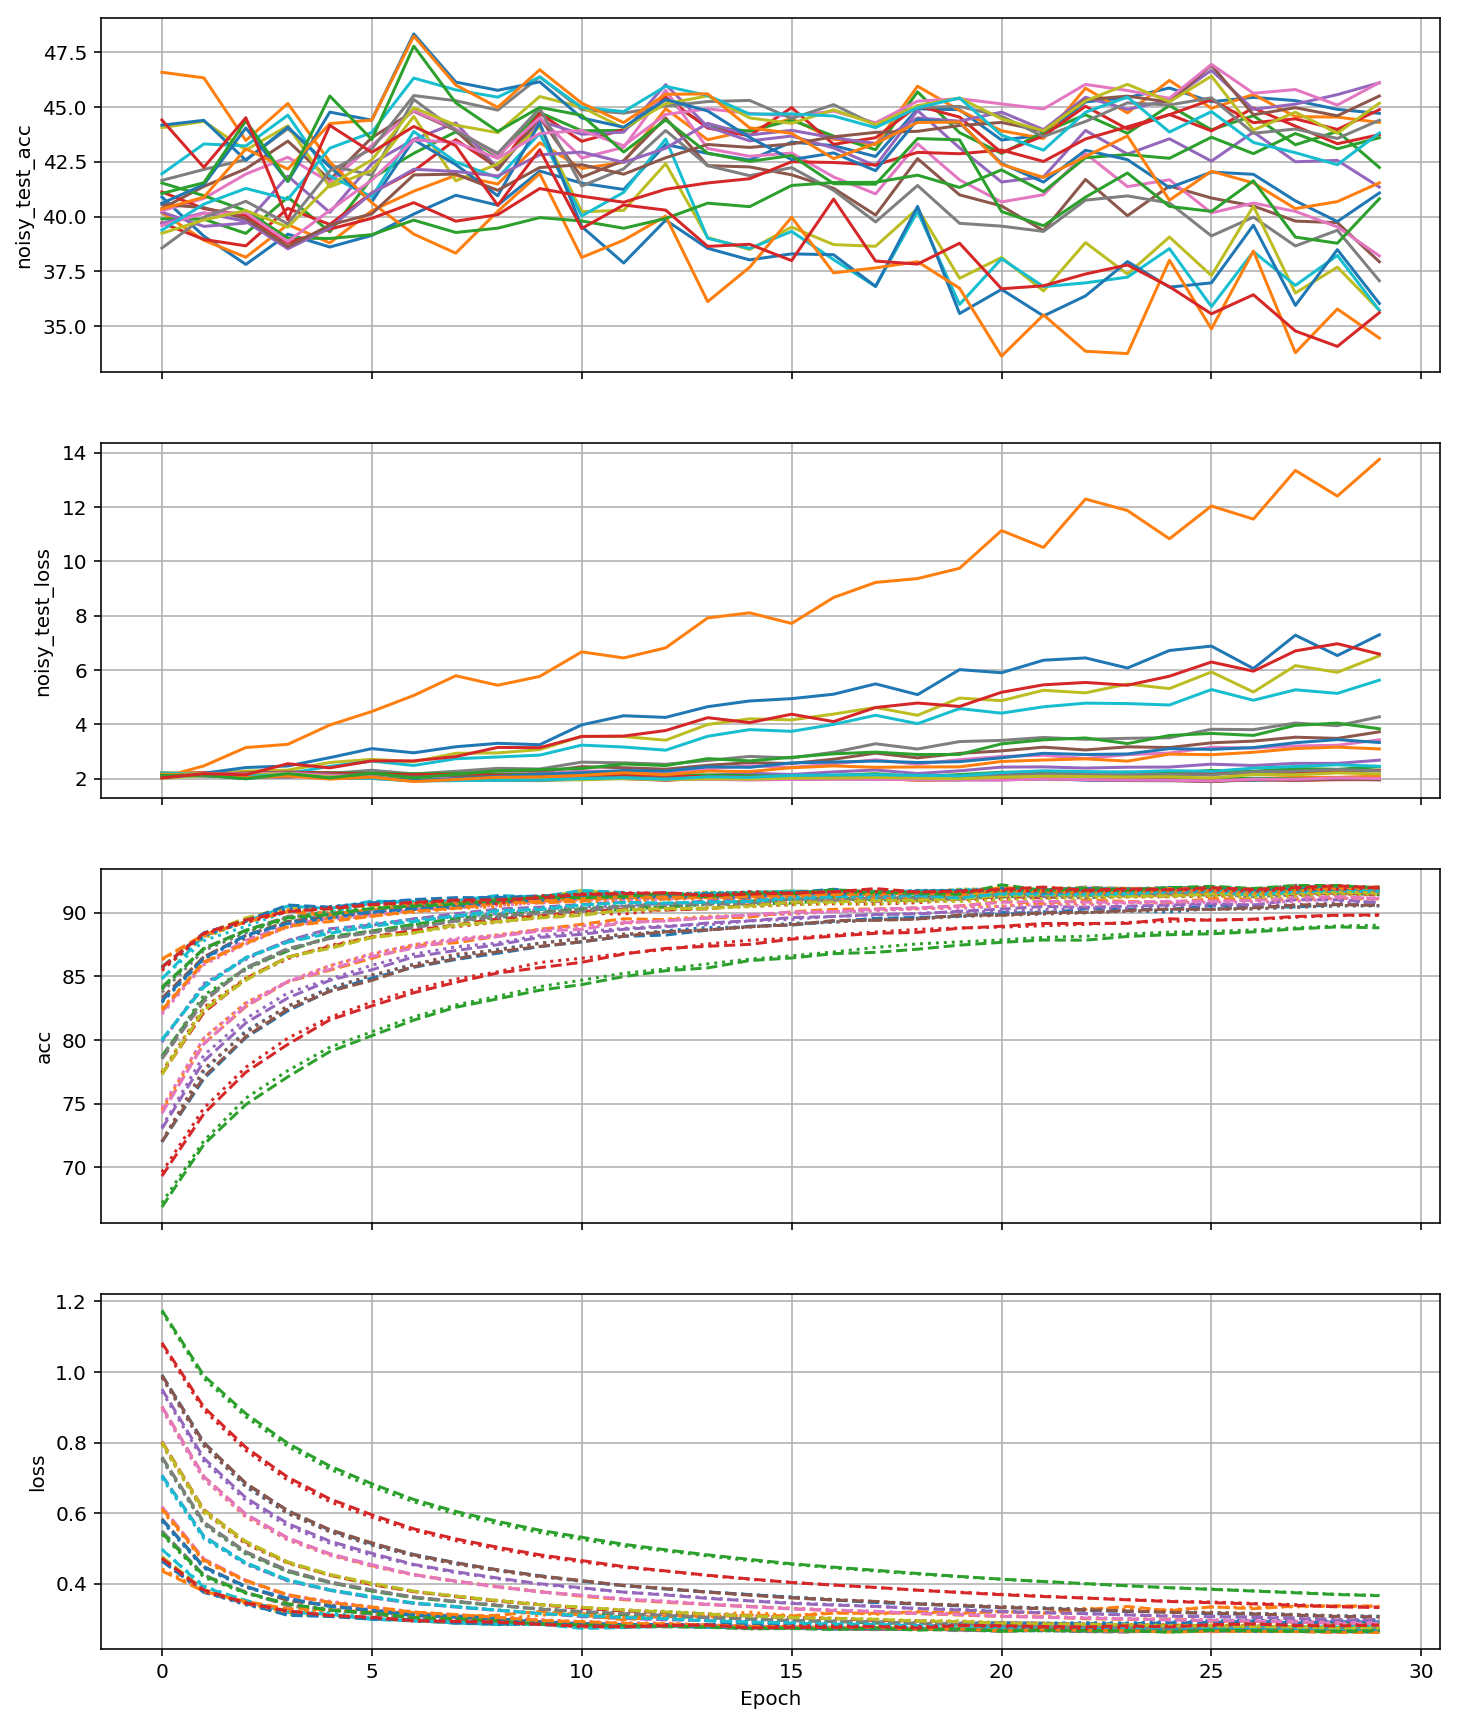

In [25]:
grid_search.plot(figsize=(12, 15), legend=False)

In [26]:
grid_search.get_best_value('val_acc')

(22, 20, 92.2)

In [27]:
grid_search.jobs[22]

{'index': 22,
 'params': {'batch_size': 128,
  'batch_size_eval': 1000,
  'learning_rate': 0.04,
  'momentum': 0.5,
  'num_epochs': 30,
  'scaling_factor': 2},
 'status': 'done',
 'history': ''}

In [31]:
utils.History.load(grid_search._get_history_filename(grid_search.jobs[22])).values['noisy_test_acc'][20]

40.23557692307692

In [18]:
utils.History.load('logs/1/6.json').params

{'alpha': 0.3,
 'batch_size': 64,
 'batch_size_eval': 1000,
 'learning_rate': 0.02,
 'momentum': 0.3,
 'num_epochs': 30,
 'num_passes': 2,
 'scaling_factor': 2}

# Experiment 2: Sequential Image Classification

In [4]:
params = dict(batch_size=64, batch_size_eval=1000, num_epochs=30, learning_rate=0.01, momentum=0.5)

## Make sequential dataset from EMNIST

In [5]:
def to_letter(index):
    return 'abcdefghijklmnopqrstuvwxyz'[index]

def to_index(letter):
    return ord(letter) - 97

In [6]:
num_allowed_seqs = 50
seq_len = 5
num_classes = 26  # mnist: 10, emnist: 26

#allowed_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))

In [7]:
allowed_seqs_letters = np.loadtxt('data/5-letter-words.txt', dtype=str)
np.random.seed(0)  # seed here so we choose the same words in each run
allowed_seqs_letters = np.random.choice(allowed_seqs_letters, num_allowed_seqs)
allowed_seqs = np.array([list(map(to_index, word)) for word in allowed_seqs_letters])

In [8]:
allowed_seqs[:10], allowed_seqs_letters[:10]

(array([[ 5, 14, 17, 20, 12],
        [ 1,  4,  6,  8, 13],
        [ 3,  0, 19,  4,  3],
        [ 6, 17,  4,  0, 19],
        [17,  0,  8, 18,  4],
        [12,  0, 17,  8,  0],
        [ 6, 17, 14, 20, 15],
        [18,  7, 14, 17, 19],
        [ 0,  6,  0,  8, 13],
        [ 8,  3,  4,  0, 11]]),
 array(['forum', 'begin', 'dated', 'great', 'raise', 'maria', 'group',
        'short', 'again', 'ideal'], dtype='<U5'))

In [9]:
np.unique(allowed_seqs, return_counts=True)
# TODO: Some letters appear very rarely in these words, gotta keep this in mind when training only on sequences. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 14, 15, 17, 18,
        19, 20, 21, 22, 24, 25]),
 array([20,  4,  8,  8, 32,  6,  7,  9, 18,  2,  8,  6, 11, 22,  6, 34, 14,
        19,  6,  2,  5,  2,  1]))

In [10]:
random_seqs = np.random.randint(0, num_classes, (num_allowed_seqs, seq_len))
random_seqs[:10]

array([[ 1,  9, 25,  0, 10],
       [20, 23,  3, 11, 18],
       [23,  2,  0,  0,  4],
       [21,  5,  6,  8, 20],
       [17, 15,  4,  9, 10],
       [24,  1,  1,  7,  9],
       [25,  3,  6, 23, 11],
       [14, 18,  0, 14,  3],
       [21, 12, 25, 10, 20],
       [11,  4,  6,  4, 15]])

In [11]:
train_dataset, val_dataset, test_dataset = datasets.load_emnist()
noisy_test_dataset = datasets.load_noisy_emnist(scaling_factor=4)

seq_train_dataset = datasets.ImageSequenceDataset(allowed_seqs, train_dataset, num_classes, num_samples=50000)
seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000)
noisy_seq_test_dataset = datasets.ImageSequenceDataset(allowed_seqs, test_dataset, num_classes, num_samples=10000, 
                                                       noisy_image_dataset=noisy_test_dataset)
random_seq_test_dataset = datasets.ImageSequenceDataset(random_seqs, test_dataset, num_classes, num_samples=10000)
noisy_random_seq_test_dataset = datasets.ImageSequenceDataset(random_seqs, test_dataset, num_classes, 
                                                              num_samples=10000, 
                                                              noisy_image_dataset=noisy_test_dataset)

kwargs = {'num_workers': 3, 'pin_memory': True} if use_cuda else {}
seq_train_loader = torch.utils.data.DataLoader(seq_train_dataset, batch_size=params['batch_size'], 
                                               shuffle=True, **kwargs)
seq_test_loader = torch.utils.data.DataLoader(seq_test_dataset, batch_size=params['batch_size_eval'], 
                                              shuffle=False, **kwargs)
noisy_seq_test_loader = torch.utils.data.DataLoader(noisy_seq_test_dataset, batch_size=params['batch_size_eval'], 
                                                    shuffle=False, **kwargs)
random_seq_test_loader = torch.utils.data.DataLoader(random_seq_test_dataset, batch_size=params['batch_size_eval'], 
                                                     shuffle=False, **kwargs)
noisy_random_seq_test_loader = torch.utils.data.DataLoader(noisy_random_seq_test_dataset, 
                                                           batch_size=params['batch_size_eval'], 
                                                           shuffle=False, **kwargs)

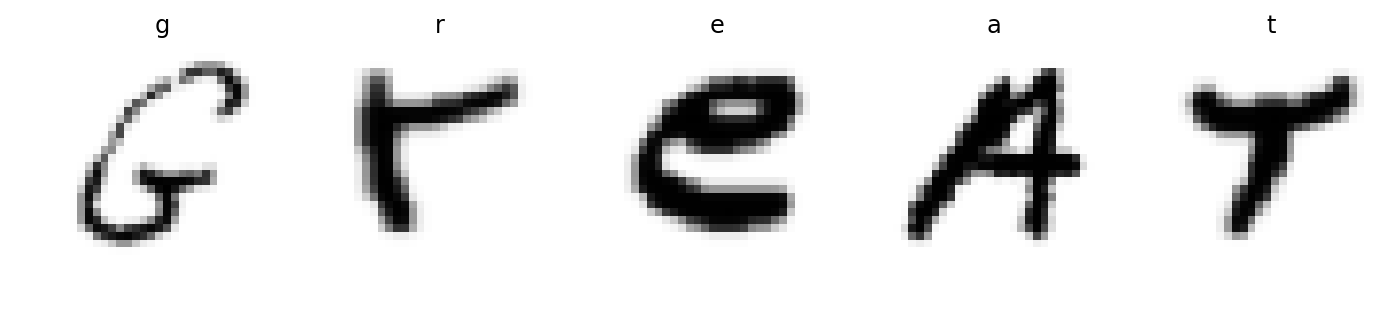

In [47]:
utils.seed_all(5)
plt.figure(figsize=(12, 2))
datasets.plot_sequence(*seq_test_dataset[3], target_transform=to_letter)
#plt.savefig('figures/sequence.png', dpi=300)

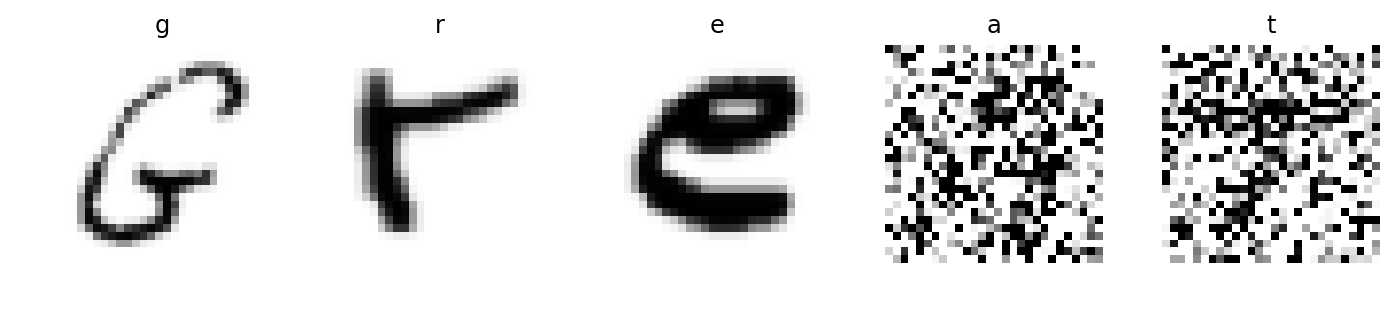

In [48]:
utils.seed_all(5)
plt.figure(figsize=(12, 2))
datasets.plot_sequence(*noisy_seq_test_dataset[3], target_transform=to_letter)
#plt.savefig('figures/sequence_noisy.png', dpi=300)

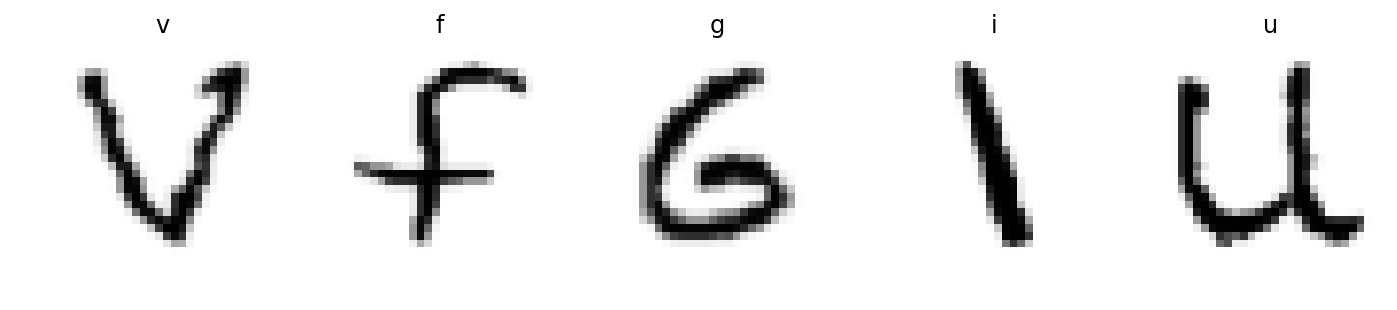

In [49]:
utils.seed_all(5)
plt.figure(figsize=(12, 2))
datasets.plot_sequence(*random_seq_test_dataset[3], target_transform=to_letter)
#plt.savefig('figures/random_sequence.png', dpi=300)

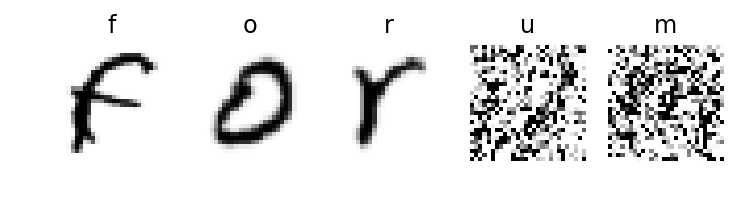

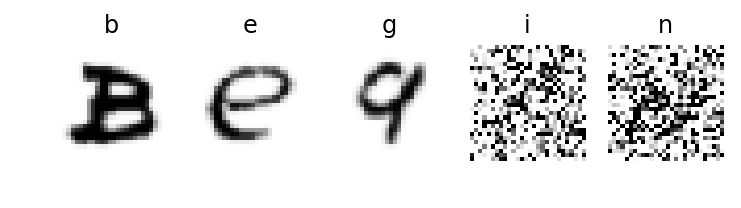

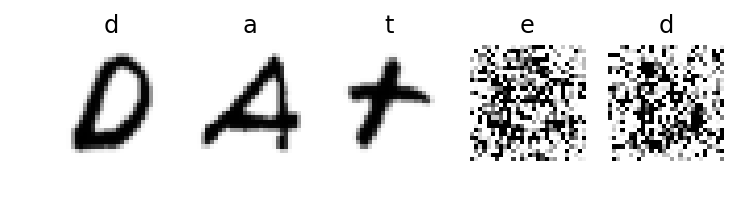

In [13]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*noisy_seq_test_dataset[i], target_transform=to_letter)

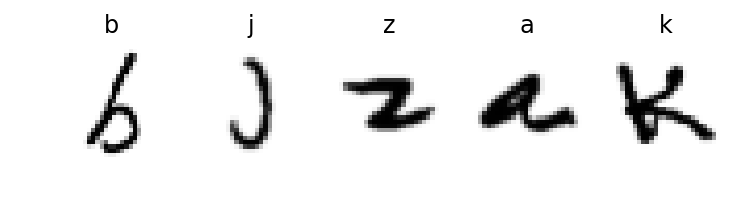

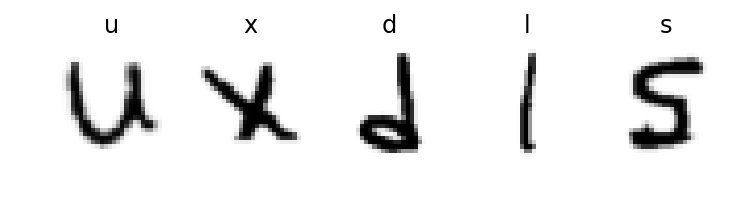

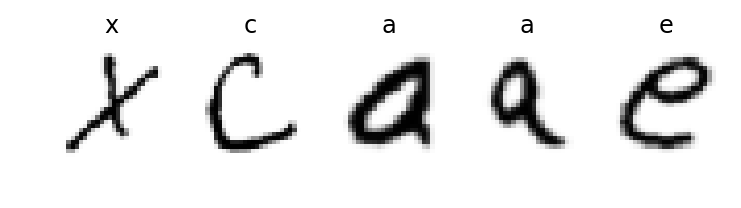

In [14]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*random_seq_test_dataset[i], target_transform=to_letter)

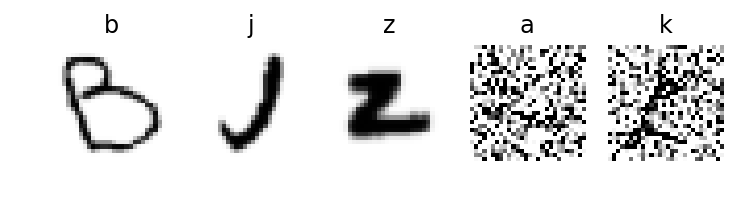

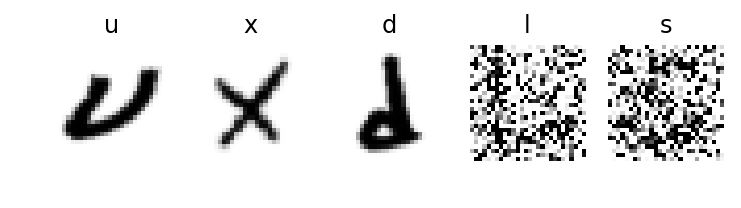

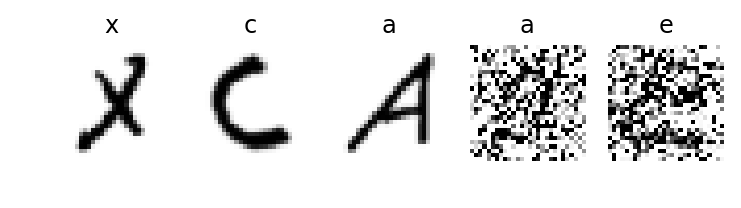

In [15]:
for i in range(3):
    plt.figure()
    datasets.plot_sequence(*noisy_random_seq_test_dataset[i], target_transform=to_letter)

## Networks

In [16]:
class SequentialLSTM(nn.Module):
    def __init__(self, num_hidden=500):
        super(SequentialLSTM, self).__init__()
        # TODO: Maybe change everything to batch_second.
        self.lstm1 = nn.LSTM(784, num_hidden, batch_first=True)
        self.lstm2 = nn.LSTM(num_hidden, 10, batch_first=True)
        
    def forward(self, inp):
        inp = inp.view(inp.shape[0], inp.shape[1], 784)
        #print(inp.shape)
        x, (hidden, cell) = self.lstm1(inp)
        # TODO: Need to add a non-linearity here?
        x, (hidden, cell) = self.lstm2(x)
        #print(x.shape, hidden.shape, cell.shape)
        #print(x.shape)
        x = F.log_softmax(x, dim=2)
        #print(x.sum(dim=(2)))
        return x

In [17]:
class SequentialFeedforwardNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5):
        super(SequentialFeedforwardNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)

    def forward(self, inp):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            x = F.relu(self.forward1(x))
            x = self.dropout(x)
            x = F.log_softmax(self.forward2(x), dim=1)
            outp[:, i] = x
            
        return outp

In [18]:
class SequentialFeedbackNet(nn.Module):
    def __init__(self, num_hidden=500, dropout=0.5, alpha=0.5):
        super(SequentialFeedbackNet, self).__init__()
        self.forward1 = nn.Linear(784, num_hidden)
        #self.forward2 = nn.Linear(num_hidden, num_hidden)
        self.forward2 = nn.Linear(num_hidden, 26)
        self.dropout = nn.Dropout(dropout)
        
        self.feedback1 = nn.Linear(num_hidden, 784)
        #self.feedback2 = nn.Linear(num_hidden, num_hidden)
        self.alpha = alpha
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, inp, plot_feedback=False):
        outp = torch.zeros(inp.shape[0], inp.shape[1], 26)
        
        feedback_activation_1 = torch.zeros(inp.shape[0], self.forward1.weight.shape[1])
        #feedback_activation_2 = torch.zeros(inp.shape[0], self.forward2.weight.shape[1])
        
        for i, x in enumerate(inp.transpose(0, 1)):
            x = x.view(-1, 784)
            
            # 1st layer.
            if plot_feedback:
                plt.figure()
                plt.imshow(feedback_activation_1[0].detach().numpy().reshape(28, 28), cmap='Greys')
            x = F.relu(self.forward1((1 - self.alpha) * x + self.alpha * feedback_activation_1))
            feedback_activation_1 = self.feedback1(x)  # for next forward pass
            
            # 2nd layer.
            #x = F.relu(self.forward2((1 - self.alpha) * x + self.alpha * feedback_activation_2))
            #feedback_activation_2 = self.feedback2(x)
            
            # 3rd (readout) layer.
            x = self.dropout(x)
            x = F.log_softmax(self.forward2(x), dim=1)
            
            outp[:, i] = x
            
        return outp

## Training

In [19]:
def train_sequential(model, device, train_loader, optimizer, epoch, params=None):
    model.train()
    for batch, (data, target) in enumerate(seq_train_loader):
        data, target = data.to(device), target.to(device)

        output = model(data)
        #print(output.shape, target.shape)
        
        # TODO: According to https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html
        #       need to do model.zero_grad() and model.hidden = model.init_hidden() here. 

        loss = F.nll_loss(output.transpose(1, 2), target)  # loss function requires transpose
        pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target)  # get the index of the max log-probability
        correct = (pred == target).sum().item()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.1f} %'.format(
                epoch, batch * len(data), len(train_loader.dataset),
                100. * batch / len(train_loader), loss.item(), 100. * correct / (len(data) * seq_len)))

In [20]:
def test_sequential(model, device, test_loader, per_position=False, params=None):
    model.eval()
    test_loss = 0
    correct = 0
    if per_position:
        correct_per_position = torch.zeros(seq_len)
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output.transpose(1, 2), target, reduction='sum').item() # sum up batch loss, loss function requires transpose
            
            pred = output.view(-1, output.shape[-1]).max(1, keepdim=True)[1].view_as(target) # get the index of the max log-probability
            correct += (pred == target).sum().item()
            if per_position:
                correct_per_position += (pred == target).float().sum(0)

    # TODO: Make this independent of seq_len (used twice!).
    test_loss /= len(test_loader.dataset) * seq_len
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f} %)'.format(
        test_loss, correct, len(test_loader.dataset) * seq_len,
        100. * correct / (len(test_loader.dataset) * seq_len)))
    if per_position:
        print('Accuracy per position:', ' | '.join(['{:.1f} %'.format(100. * corr.item() / len(test_loader.dataset)) for corr in correct_per_position]))

In [21]:
#model = SequentialFeedforwardNet().to(device)
model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)

In [22]:
# Transfer feedforward parameters from model that was trained on EMNIST images (w/o sequences). 
trained_ff_model = torch.load('data/models/ff_net.pt')
model.forward1.weight.data = trained_ff_model.forward1.weight.data.clone()
model.forward1.bias.data = trained_ff_model.forward1.bias.data.clone()
model.forward2.weight.data = trained_ff_model.forward2.weight.data.clone()
model.forward2.bias.data = trained_ff_model.forward2.bias.data.clone()

In [23]:
test_sequential(model, device, seq_test_loader, per_position=True)
print()
print('Testing on noisy dataset:')
test_sequential(model, device, noisy_seq_test_loader, per_position=True)
print()
print('Testing on random words (without noise):')
test_sequential(model, device, random_seq_test_loader, per_position=True)
print()
print('Testing on random words (with noise):')
test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)

Test set: Average loss: 0.4143, Accuracy: 45533/50000 (91.1 %)
Accuracy per position: 91.2 % | 91.7 % | 90.5 % | 89.5 % | 92.5 %

Testing on noisy dataset:
Test set: Average loss: 3.1706, Accuracy: 28703/50000 (57.4 %)
Accuracy per position: 91.2 % | 91.9 % | 90.1 % | 7.8 % | 6.0 %

Testing on random words (without noise):
Test set: Average loss: 0.4116, Accuracy: 45324/50000 (90.6 %)
Accuracy per position: 90.0 % | 92.2 % | 90.2 % | 89.8 % | 91.0 %

Testing on random words (with noise):
Test set: Average loss: 3.2161, Accuracy: 29070/50000 (58.1 %)
Accuracy per position: 89.6 % | 92.6 % | 90.2 % | 12.2 % | 6.1 %


In [24]:
model.forward1.weight.requires_grad = False
model.forward1.bias.requires_grad = False
model.forward2.weight.requires_grad = False
model.forward2.bias.requires_grad = False

In [25]:
#model = SequentialFeedforwardNet().to(device)
#model = SequentialLSTM().to(device)
#model = SequentialFeedbackNet(dropout=0.5, alpha=0.5).to(device)
# TODO: Use rmsprop or another optimizer which is good for LSTMs.
#optimizer = optim.Adam(model.parameters(), lr=0.0001)
#optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=params['momentum'])
optimizer = optim.SGD([p for p in model.parameters() if p.requires_grad], lr=0.00001, momentum=params['momentum'])

for epoch in range(params['num_epochs']):
    print('Epoch {}/{}'.format(epoch+1, params['num_epochs']))
    start_time = time.time()
    train_sequential(model, device, seq_train_loader, optimizer, epoch+1)
    print('Took', time.time()-start_time, 'seconds')
    
    print()
    test_sequential(model, device, seq_test_loader, per_position=True)
    print()
    print('Testing on noisy dataset:')
    test_sequential(model, device, noisy_seq_test_loader, per_position=True)
    print()
    print('Testing on random words (without noise):')
    test_sequential(model, device, random_seq_test_loader, per_position=True)
    print()
    print('Testing on random words (with noise):')
    test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)
    print()
    print()

Epoch 1/30
Train Epoch: 1 [0/50000 (0%)]	Loss: 0.521388	Accuracy: 90.6 %
Train Epoch: 1 [6400/50000 (13%)]	Loss: 0.466175	Accuracy: 87.8 %
Train Epoch: 1 [12800/50000 (26%)]	Loss: 0.417471	Accuracy: 90.3 %
Train Epoch: 1 [19200/50000 (38%)]	Loss: 0.393441	Accuracy: 91.9 %
Train Epoch: 1 [25600/50000 (51%)]	Loss: 0.405408	Accuracy: 89.4 %
Train Epoch: 1 [32000/50000 (64%)]	Loss: 0.410995	Accuracy: 87.8 %
Train Epoch: 1 [38400/50000 (77%)]	Loss: 0.518204	Accuracy: 86.6 %
Train Epoch: 1 [44800/50000 (90%)]	Loss: 0.497366	Accuracy: 87.5 %
Took 15.778257846832275 seconds

Test set: Average loss: 0.3067, Accuracy: 45974/50000 (91.9 %)
Accuracy per position: 90.8 % | 91.8 % | 93.0 % | 92.8 % | 91.2 %

Testing on noisy dataset:
Test set: Average loss: 3.4673, Accuracy: 30384/50000 (60.8 %)
Accuracy per position: 91.1 % | 92.0 % | 93.2 % | 13.3 % | 14.1 %

Testing on random words (without noise):
Test set: Average loss: 0.3996, Accuracy: 44339/50000 (88.7 %)
Accuracy per position: 90.1 % | 91.0

Test set: Average loss: 4.2513, Accuracy: 25695/50000 (51.4 %)
Accuracy per position: 89.8 % | 82.0 % | 70.3 % | 10.0 % | 4.9 %


Epoch 8/30
Train Epoch: 8 [0/50000 (0%)]	Loss: 0.356458	Accuracy: 87.2 %
Train Epoch: 8 [6400/50000 (13%)]	Loss: 0.270346	Accuracy: 93.8 %
Train Epoch: 8 [12800/50000 (26%)]	Loss: 0.319424	Accuracy: 90.6 %
Train Epoch: 8 [19200/50000 (38%)]	Loss: 0.306050	Accuracy: 92.8 %
Train Epoch: 8 [25600/50000 (51%)]	Loss: 0.323266	Accuracy: 92.8 %
Train Epoch: 8 [32000/50000 (64%)]	Loss: 0.314242	Accuracy: 92.8 %
Train Epoch: 8 [38400/50000 (77%)]	Loss: 0.318817	Accuracy: 92.2 %
Train Epoch: 8 [44800/50000 (90%)]	Loss: 0.348419	Accuracy: 90.3 %
Took 12.775565147399902 seconds

Test set: Average loss: 0.2805, Accuracy: 46517/50000 (93.0 %)
Accuracy per position: 90.6 % | 94.7 % | 94.3 % | 93.4 % | 92.2 %

Testing on noisy dataset:
Test set: Average loss: 2.5427, Accuracy: 31053/50000 (62.1 %)
Accuracy per position: 91.2 % | 94.2 % | 94.2 % | 20.1 % | 10.9 %

Testing on

Test set: Average loss: 0.8946, Accuracy: 36455/50000 (72.9 %)
Accuracy per position: 89.2 % | 75.7 % | 61.2 % | 67.6 % | 70.9 %

Testing on random words (with noise):
Test set: Average loss: 3.3585, Accuracy: 23972/50000 (47.9 %)
Accuracy per position: 89.8 % | 75.6 % | 60.5 % | 8.7 % | 5.0 %


Epoch 15/30
Train Epoch: 15 [0/50000 (0%)]	Loss: 0.309397	Accuracy: 90.3 %
Train Epoch: 15 [6400/50000 (13%)]	Loss: 0.317251	Accuracy: 90.3 %
Train Epoch: 15 [12800/50000 (26%)]	Loss: 0.293049	Accuracy: 90.3 %
Train Epoch: 15 [19200/50000 (38%)]	Loss: 0.332423	Accuracy: 92.2 %
Train Epoch: 15 [25600/50000 (51%)]	Loss: 0.339705	Accuracy: 89.4 %
Train Epoch: 15 [32000/50000 (64%)]	Loss: 0.342427	Accuracy: 91.6 %
Train Epoch: 15 [38400/50000 (77%)]	Loss: 0.263039	Accuracy: 94.1 %
Train Epoch: 15 [44800/50000 (90%)]	Loss: 0.333864	Accuracy: 89.4 %
Took 14.991351127624512 seconds

Test set: Average loss: 0.2392, Accuracy: 46990/50000 (94.0 %)
Accuracy per position: 91.3 % | 95.2 % | 94.1 % | 95.0 % 

Test set: Average loss: 1.1416, Accuracy: 38553/50000 (77.1 %)
Accuracy per position: 90.8 % | 95.5 % | 95.2 % | 45.6 % | 58.4 %

Testing on random words (without noise):
Test set: Average loss: 1.4788, Accuracy: 30534/50000 (61.1 %)
Accuracy per position: 89.6 % | 66.8 % | 47.7 % | 51.8 % | 49.3 %

Testing on random words (with noise):
Test set: Average loss: 4.1950, Accuracy: 22153/50000 (44.3 %)
Accuracy per position: 90.3 % | 67.0 % | 47.7 % | 8.2 % | 8.3 %


Epoch 22/30
Train Epoch: 22 [0/50000 (0%)]	Loss: 0.235862	Accuracy: 95.0 %
Train Epoch: 22 [6400/50000 (13%)]	Loss: 0.240280	Accuracy: 95.0 %
Train Epoch: 22 [12800/50000 (26%)]	Loss: 0.306264	Accuracy: 92.2 %
Train Epoch: 22 [19200/50000 (38%)]	Loss: 0.236124	Accuracy: 93.1 %
Train Epoch: 22 [25600/50000 (51%)]	Loss: 0.288942	Accuracy: 93.1 %
Train Epoch: 22 [32000/50000 (64%)]	Loss: 0.300319	Accuracy: 91.2 %
Train Epoch: 22 [38400/50000 (77%)]	Loss: 0.333501	Accuracy: 90.0 %
Train Epoch: 22 [44800/50000 (90%)]	Loss: 0.296078

Took 15.471865177154541 seconds

Test set: Average loss: 0.1846, Accuracy: 47643/50000 (95.3 %)
Accuracy per position: 91.0 % | 96.1 % | 95.8 % | 95.8 % | 97.7 %

Testing on noisy dataset:
Test set: Average loss: 0.8324, Accuracy: 41178/50000 (82.4 %)
Accuracy per position: 91.0 % | 95.6 % | 95.5 % | 59.5 % | 70.2 %

Testing on random words (without noise):
Test set: Average loss: 2.1536, Accuracy: 25802/50000 (51.6 %)
Accuracy per position: 89.8 % | 58.4 % | 34.1 % | 39.5 % | 36.2 %

Testing on random words (with noise):
Test set: Average loss: 5.1383, Accuracy: 19731/50000 (39.5 %)
Accuracy per position: 89.7 % | 58.1 % | 34.7 % | 8.0 % | 6.8 %


Epoch 29/30
Train Epoch: 29 [0/50000 (0%)]	Loss: 0.258161	Accuracy: 92.8 %
Train Epoch: 29 [6400/50000 (13%)]	Loss: 0.283852	Accuracy: 93.1 %
Train Epoch: 29 [12800/50000 (26%)]	Loss: 0.256130	Accuracy: 93.8 %
Train Epoch: 29 [19200/50000 (38%)]	Loss: 0.262334	Accuracy: 93.8 %
Train Epoch: 29 [25600/50000 (51%)]	Loss: 0.187404	Accuracy: 95.9

In [136]:
#torch.save(model, 'data/models/fb_net.pt')

/Users/jrieke/anaconda2/envs/py3/lib/python3.6/site-packages/torch/serialization.py:250: UserWarning: Couldn't retrieve source code for container of type SequentialFeedbackNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [137]:
#torch.load('data/models/fb_net.pt')

SequentialFeedbackNet(
  (forward1): Linear(in_features=784, out_features=500, bias=True)
  (forward2): Linear(in_features=500, out_features=500, bias=True)
  (forward3): Linear(in_features=500, out_features=26, bias=True)
  (dropout): Dropout(p=0.5)
  (feedback1): Linear(in_features=500, out_features=784, bias=True)
  (feedback2): Linear(in_features=500, out_features=500, bias=True)
)

In [138]:
print('Testing on random words (without noise):')
test_sequential(model, device, random_seq_test_loader, per_position=True)
print()
print('Testing on random words (with noise):')
test_sequential(model, device, noisy_random_seq_test_loader, per_position=True)

Testing on random words (without noise):
Test set: Average loss: 0.4670, Accuracy: 45167/50000 (90.3 %)
Accuracy per position: 89.2 % | 92.3 % | 89.6 % | 89.5 % | 91.1 %

Testing on random words (with noise):
Test set: Average loss: 2.2322, Accuracy: 29116/50000 (58.2 %)
Accuracy per position: 89.1 % | 91.9 % | 89.4 % | 12.9 % | 7.9 %


In [140]:
test_sequential(model, device, seq_test_loader, per_position=True)

Test set: Average loss: 0.4314, Accuracy: 44944/50000 (89.9 %)
Accuracy per position: 86.1 % | 90.6 % | 93.0 % | 91.6 % | 88.1 %
